#Example calculation of the ground state of Bose-Hubbard model




In [27]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [28]:
# including necessary files and latex fonts
!cp drive/MyDrive/DNN/HubbardNet_gpu.py .
!cp drive/MyDrive/DNN/matrix_element.py .
!sudo apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended
!pip install matplotlib==3.2.2

Reading package lists... Done
Building dependency tree       
Reading state information... Done
texlive-latex-recommended is already the newest version (2017.20180305-1).
cm-super is already the newest version (0.3.4-11).
dvipng is already the newest version (1.15-1).
texlive-latex-extra is already the newest version (2017.20180305-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
import time 
import torch
import matplotlib.pyplot as plt
import matplotlib
#from matplotlib import rc
import numpy as np

from HubbardNet_gpu import *
import matrix_element as me

from os import path
import os
from copy import copy


In [2]:
# Go to Edit -> Notebook Settings and select "GPU" from the hardware accelerator dropdown. 
# If this is on, GPU is enabled by default

use_gpu = False

# Check to see if gpu is available. If it is, use it else use the cpu
if torch.cuda.is_available() and use_gpu:
    device = torch.device('cuda')
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    print('Using GPU.')
else:
    device = torch.device('cpu')
    torch.set_default_tensor_type('torch.DoubleTensor')

    if not torch.cuda.is_available() and use_gpu: 
        use_gpu = False 
        print('GPU not available. Using CPU.')
    else: 
        print('Using CPU.')


Using CPU.


In [14]:
torch.set_num_threads(6)

In [3]:
torch.get_num_threads()

12

In [108]:
torch.cuda.synchronize()

In [5]:
torch.set_num_interop_threads(20)

In [4]:
torch.get_num_interop_threads()

12

In [20]:
device_properties = torch.cuda.get_device_properties(0)
print(device_properties)

_CudaDeviceProperties(name='Quadro RTX 5000', major=7, minor=5, total_memory=15931MB, multi_processor_count=48)


In [15]:
import os
print(os.cpu_count() )

24


In [3]:
N_list = [3]
N = N_list[0]
model_list = []

M = 16
#w = M
w = 4
#h = int(M/w)
h = 4
pbc = False

for (n_idx, N) in enumerate(N_list): 
    O = N
    
    model = me.Bose_Hubbard(N, O, w=w, h=h, M=M, pbc=pbc)
    model_list.append(model)
    
print("The size of the Hamiltonian is {}".format(model.tot_states))

t = 1 
U_max = 5
V = 0
U_list_all = np.arange(1, U_max+1, .25)
#U_list_all =np.array([4])
mu_list_all = np.linspace(0, 10, 5)
mu_list_all = np.array([0.])


The size of the Hamiltonian is 816


In [4]:
from tqdm import tqdm

## NN

S = 50 # number of sample of the MH sampler (not used)
init = 1 # the first state to sample in Metropolis Hastings (has nothing to do with the optimizer!) (not used)

# Network parameters
D_hid = 400 # the number ofneurons in the hidden layer
lr = 5e-6 # learning rate 
epochs = 70000
loss_diff = 1e-7
grad_cut = 1e-6
check_point = 100 # print out the energy every X points
use_sampler = False # for now, only support ground state (not working anyway)

# Model parameters
U_train = np.ones(3)*2
t_train = 1.

#U_train = np.array([2., 6, 9])
#U_train = np.array([2.,4, 6, 9])
#U_train =[3.5,4,5,6,8,10,12,14]
#U_train =[0.001,0.01,0.1,1,3,6,8,10,12,15,18,20,50,100,200,300,400,500,600,700,800,900,1000]
#U_train =[1,3,6,8,10,12,15,18,20,50,100,200,300,400,500,600,700,800,900,1000]
#U_train =[1,3,6,8]
#U_train =[1,3,6,8,10,13,16,20]
#U_train =[0.001,0.01,0.1,0.5,1]
#U_train =[3.12,3.2,3,3.6,2.8,4,2.4]
#U_train =[40,42,44,46]
#U_train =[0.05,0.5,5,50]
#U_train =[0.05,0.1,0.5,1,5,20,50]
U_train = np.logspace(-2, 2, 9, endpoint = True)
#U_train = [1]
#U_train =[0.05,0.5,5,50]
#U_train =np.linspace(2,12,2)
mu_train = np.zeros_like(U_train)

min_state = 0
max_state = 1

n_excited = max_state - 1

# paths to save and load weights 
#fpath ='/storage/disqs/phrczh/HubbardNet/weights'

#t0 = time.time()

loss_all = [] 
penalty_all = []
nn = []

# filepath for excited states
fname = "./weights/2D-ADAM-weights_M{}_N{}_w{}_h{}_V{}_D{}lr{}U_train{}".format(M,N,w,h,V,D_hid,lr,U_train)


In [5]:
t0 = time.time()
def call_NN(lr, n_excited):
    if n_excited: 
        if n_excited == 1 :
            load_states_indv = [0]
        else:
            load_states_indv = range(1, n_excited)
        gs_flag = False
        es_flag = True

    else: # ground states
        load_states_indv = [0]
        gs_flag = True
        es_flag = False
    
    load_states = np.max(load_states_indv)  # total number of states being fixed 
  
    params = {'D_hid': D_hid, 
              'step_size': lr, 
              'max_iteration':epochs,
              'check_point': check_point,
              'loss_diff': loss_diff, 
              'steps': 1000, # reset learning every N steps
              'loss_check_steps': 50, # check the local every N steps
              'grad_cut': grad_cut,  # stopping condition in the total gradient 
              'weight_init': False, 
              'zero_bias': False, 
              'gs_epochs': 1000, # the maximum number of steps to minimize the ground state
              'gs_flag': gs_flag, # ground state only
              'es_flag': es_flag,  # excited state only
              'regularization': True, 
              'load_states': load_states, # the number of states loaded 
              'load_states_indv': load_states_indv, 
              'rand_steps': 5000, 
              'load_weights_from_previous_state': False, # randomize the projection every N steps
              'use_gpu': use_gpu, 
              'weight_decay': 0,
              'perturb_amp': 0.00, 
              'dropout': 0.0}
  
    print("Begin optimizing for state {}".format(n_excited))

    fc1, Loss_history, dot_history, all_E_list = train_NN(model_list, N_list, mu_train, U_train, t_train, V, S, params, fname, \
                                            use_sampler=use_sampler, init=init, loadweights=False,\
                                            fname_load=fname, n_excited=n_excited)

    return fc1, Loss_history, dot_history



for n_excited in range(min_state, max_state):
    
    fc1, Loss_history, dot_history = call_NN(lr, n_excited)

    nn.append(fc1)
    loss_all.append(Loss_history)
    penalty_all.append(dot_history)
    
tf = time.time()
print("Training time = {} seconds.".format(tf-t0))
#np.savetxt(f'./time/M-{M}-N-{N}-U_train-{U_train}-lr-{lr}-num_th-{torch.get_num_threads()}-interop-{torch.get_num_interop_threads()}-use_gpu-{use_gpu}-adam.csv',[tf-t0])
#np.savetxt(f'./time/steps-1000-epochs-{epochs}-ADAM-M-{M}-N-{N}-U_train-{U_train}-lr-{lr}-num_th-{torch.get_num_threads()}-interop-{torch.get_num_interop_threads()}-use_gpu-{use_gpu}.csv',[tf-t0])
#np.savetxt(f'./time/loss_check_steps-10-ADAM-M-{M}-N-{N}-U_train-{U_train}-lr-{lr}-num_th-{torch.get_num_threads()}-interop-{torch.get_num_interop_threads()}-use_gpu-{use_gpu}.csv',[tf-t0])
np.savetxt(f'./time/2D-ADAM-M-{M}-N-{N}-w{w}-h{h}-len_U_train-{len(U_train)}-lr-{lr}-num_th-{torch.get_num_threads()}-interop-{torch.get_num_interop_threads()}-use_gpu-{use_gpu}.csv',[tf-t0])

Begin optimizing for state 0
0.0


/storage/disqs/phrczh/HubbardNet/2D-ground-state/HubbardNet_gpu.py:728: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at  /storage/csc/pfsrqd/build/PyTorch/1.12.1/foss-2022a-CUDA-11.7.0/pytorch-v1.12.1/aten/src/ATen/native/Copy.cpp:250.)
  H_list.append(torch.tensor(H, dtype=torch.double))
/storage/disqs/phrczh/HubbardNet/2D-ground-state/HubbardNet_gpu.py:416: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /storage/csc/pfsrqd/build/PyTorch/1.12.1/foss-2022a-CUDA-11.7.0/pytorch-v1.12.1/torch/csrc/utils/tensor_new.cpp:201.)
  all_states = torch.tensor([model_list[k].all_states[i].reshape((1,-1))
/software/easybuild/software/PyTorch/1.12.1-foss-2022a-CUDA-11.7.0/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:728: UserWarning: To get the last learning rate computed

Iteration 0, current learning rate 5e-06, loss -8.496351842516566, total gradient 0.10317349630072958
Iteration 100, current learning rate 4.8752272094996e-06, loss -8.664719893347595, total gradient 0.275532078546359
Iteration 200, current learning rate 4.517940706966807e-06, loss -8.866717263374092, total gradient 0.4068689323337223
Iteration 300, current learning rate 3.963126519628141e-06, loss -9.021164951644504, total gradient 0.40338182509488785
Iteration 400, current learning rate 3.265093723254121e-06, loss -9.03080233220911, total gradient 0.2808552177122505
Iteration 500, current learning rate 2.4921706279425816e-06, loss -9.027479960073064, total gradient 0.1659812698743653
Iteration 600, current learning rate 1.720016325896378e-06, loss -9.05231445174773, total gradient 0.11104379341614753
Iteration 700, current learning rate 1.0242146490812126e-06, loss -9.070839976685273, total gradient 0.09141757334698705
Iteration 800, current learning rate 4.7287548480451535e-07, loss

In [6]:
np.savetxt(f'./time/2D-ADAM-M-{M}-N-{N}-w{w}-h{h}-len_U_train-{len(U_train)}-lr-{lr}-num_th-{torch.get_num_threads()}-interop-{torch.get_num_interop_threads()}-use_gpu-{use_gpu}.csv',[tf-t0])

In [131]:
torch.cuda.memory_allocated() / torch.cuda.max_memory_allocated()

0.001602489866224124

# Time for ED

In [162]:
t0 = time.time()
E_all = np.zeros(( len(U_train), model.tot_states) )
# check solution 
for (i, U) in enumerate(U_train):
    _, _, H = model.H_Bose_Hubbard(t, U, V=V, mu=mu_train[i])
    evals, evecs = np.linalg.eig(H)
    idx = np.argsort(evals)
    evecs = evecs[:,idx]
    evals = evals[idx]
    E_all[i] = evals
tf = time.time()
print("Exact diagonalization time = {} seconds.".format(tf-t0))
np.savetxt(f'./time/ED/M-{M}-N-{N}-U_train-{U_train}.csv',[tf-t0])

Exact diagonalization time = 0.4347054958343506 seconds.


/tmp/ipykernel_519056/3703171021.py:10: ComplexWarning: Casting complex values to real discards the imaginary part
  E_all[i] = evals


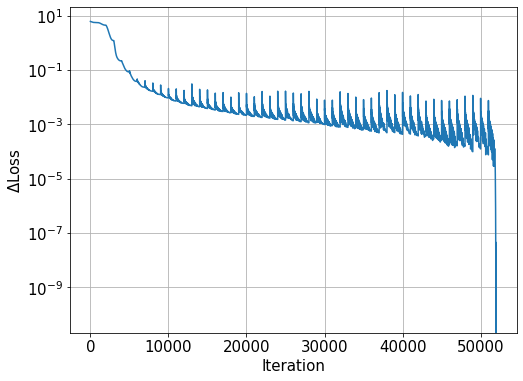

In [68]:
# plt.rcParams.update({'font.size': 14})
# plt.rc('text',usetex=True)
# #font = {'family':'serif','size':16}
# font = {'family':'serif','size':25, 'serif': ['computer modern roman']}
# plt.rc('font',**font)
# matplotlib.rcParams['text.latex.preamble']=[r'\usepackage{amsmath}']
# rc('text', usetex=True)
#U_train=[2,8]
Loss_history=np.genfromtxt(f'./loss-history/2D-ADAM-M-{M}-N-{N}-U_train-{U_train}-lr{lr}-w{w}-h{h}.csv')
for i in range(1): 
    #Loss_history = loss_all[i]
    Loss_history = np.array(Loss_history)
    
    fig,ax=plt.subplots(figsize=(8,6))
    ax.plot(Loss_history - np.min(Loss_history), '-', label='loss')
    ax.set_xlabel("Iteration")
    ax.set_ylabel(r"$\Delta$Loss",fontsize=15)
    # ax.set_title("U/t = {}".format(U_train))
    ax.set_yscale('log')
    
    
    # ax.plot(dot_history, '-', label='regularization')
    ax.set_xlabel("Iteration",fontsize=15)
    # ax.set_ylabel("Dot product")
    # ax.set_title("U/t = {}".format(U_train))
    # ax.legend()
    #plt.savefig('./figures/loss/loss_M{}N{}n{}lr{}Utrain{}-adam.pdf'.format(M,N,range(min_state, max_state)[i],lr,U_train), format='pdf',bbox_inches='tight')
    #plt.savefig('./new-loss/new-figures/loss/ADAM-loss_cc{}M{}N{}n{}lr{}Utrain{}.pdf'.format(cc,M,N,range(min_state, max_state)[i],lr,U_train), format='pdf',bbox_inches='tight')
    plt.yticks(fontsize=15)
    plt.xticks(fontsize=15)
    plt.grid()
    plt.savefig(f"./paper-2D-ground-state/2D-ground-state-deltaloss-M-{M}-N-{N}-w-{w}-h-{h}-len_U_train-{len(U_train)}.pdf",bbox_inches='tight',dpi=1000)   
    plt.show()
    

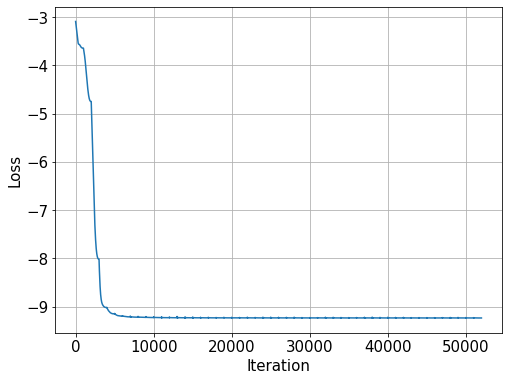

In [69]:
for i in range(1): 
    #Loss_history = loss_all[i]
    Loss_history = np.array(Loss_history)
    
    fig,ax=plt.subplots(figsize=(8,6))
    ax.plot(Loss_history , '-', label='loss')
    ax.set_xlabel("Iteration")
    ax.set_ylabel(r"Loss",fontsize=15)
    # ax.set_title("U/t = {}".format(U_train))
    #ax.set_yscale('log')
    
    
    # ax.plot(dot_history, '-', label='regularization')
    ax.set_xlabel("Iteration",fontsize=15)
    # ax.set_ylabel("Dot product")
    # ax.set_title("U/t = {}".format(U_train))
    # ax.legend()
    #plt.savefig('./figures/loss/loss_M{}N{}n{}lr{}Utrain{}-adam.pdf'.format(M,N,range(min_state, max_state)[i],lr,U_train), format='pdf',bbox_inches='tight')
    #plt.savefig('./new-loss/new-figures/loss/ADAM-loss_cc{}M{}N{}n{}lr{}Utrain{}.pdf'.format(cc,M,N,range(min_state, max_state)[i],lr,U_train), format='pdf',bbox_inches='tight')
    plt.yticks(fontsize=15)
    plt.xticks(fontsize=15)
    plt.grid()
    plt.savefig(f"./paper-2D-ground-state/2D-ground-state-loss-M-{M}-N-{N}-w-{w}-h-{h}-len_U_train-{len(U_train)}.pdf",bbox_inches='tight',dpi=1000)   
    plt.show()
    

In [374]:
E_all = np.zeros(( len(U_train), model.tot_states) )
# check solution 
for (i, U) in enumerate(U_train):
    _, _, H = model.H_Bose_Hubbard(t, U, V=V, mu=mu_train[i])
    evals, evecs = np.linalg.eig(H)
    idx = np.argsort(evals)
    evecs = evecs[:,idx]
    evals = evals[idx]
    E_all[i] = evals

/tmp/ipykernel_519056/3475991747.py:9: ComplexWarning: Casting complex values to real discards the imaginary part
  E_all[i] = evals


# Saving loss history 

In [8]:
np.savetxt(f'./loss-history/2D-ADAM-M-{M}-N-{N}-U_train-{U_train}-lr{lr}-w{w}-h{h}.csv',Loss_history)

In [17]:
Loss_history=np.genfromtxt(f'./loss-history/ADAM-M-{M}-N-{N}-U_train-{U_train}-lr{lr}.csv')

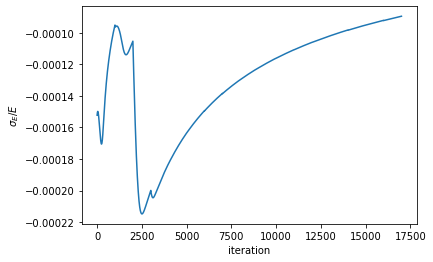

In [8]:
dd=[]
for i in range (1,len(Loss_history)):
    dd.append(i)
dd=np.array(dd)
for i in range (1,len(Loss_history)):
    delta_loss=np.sqrt(np.cumsum(np.diff(Loss_history)**2)/dd)/np.mean(Loss_history[:i+1])
    #delta_loss_squared.append((Loss_history[i]-min(Loss_history[:i+1]))**2)
plt.plot(delta_loss[:])
plt.xlabel('iteration')
plt.ylabel(r'$\sigma_{E}/E$')
plt.savefig('./figures/2D-loss/2D-ADAM-sigma_M{}N{}lr{}Utrain{}w{}h{}.pdf'.format(M,N,lr,U_train,w,h), format='pdf',bbox_inches='tight')
plt.show()
#plt.plot(delta_loss_squared[:])
#plt.show()


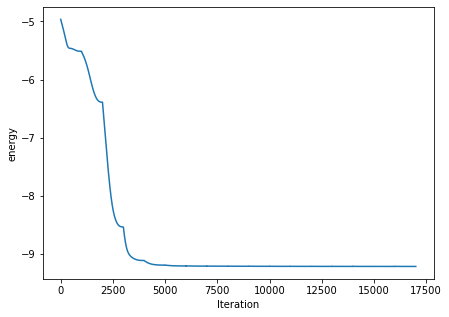

In [9]:
for i in range(1): 
    Loss_history = loss_all[i]
    Loss_history = np.array(Loss_history)
    
    fig,ax=plt.subplots(figsize=(7,5))
    ax.plot(Loss_history , '-', label='loss')
    ax.set_xlabel("Iteration")
    ax.set_ylabel("energy")
    # ax.set_title("U/t = {}".format(U_train))
    #ax.set_yscale('log')
    #ax.set_ylim(-2,2)
    
    # ax.plot(dot_history, '-', label='regularization')
    ax.set_xlabel("Iteration")
    # ax.set_ylabel("Dot product")
    # ax.set_title("U/t = {}".format(U_train))
    # ax.legend()
    #plt.savefig('./figures/loss/loss_M{}N{}n{}lr{}Utrain{}-adam.pdf'.format(M,N,range(min_state, max_state)[i],lr,U_train), format='pdf',bbox_inches='tight')
    plt.savefig('./figures/2D-loss/2D-ADAM-absenergy_M{}N{}n{}lr{}Utrain{}w{}h{}.pdf'.format(M,N,range(min_state, max_state)[i],lr,U_train,w,h), format='pdf',bbox_inches='tight')
    plt.show()

In [13]:
# delta_loss=[]
# delta_loss_squared=[]
# for i in range (len(Loss_history)):
#     delta_loss.append(Loss_history[i]-min(Loss_history[:i+1])/(i*Loss_history[i]))
#     delta_loss_squared.append((Loss_history[i]-min(Loss_history[:i+1]))**2)
# plt.plot(delta_loss[:])
# plt.xlabel('iteration')
# plt.ylabel(r'$\sigma_{E}/E$')
# plt.show()
# #plt.plot(delta_loss_squared[:])
# #plt.show()


In [15]:
delta_loss.index(max(delta_loss[:1200]))

1001

# Saving training and testing energy

#U_test = np.logspace(0, 2, 61, endpoint = True) for Mott phase

U_test = np.logspace(-3, 2, 121, endpoint = True) for superfluid phase

In [9]:
#U_test = np.linspace(1.5, 9.5, 20)
#U_test = np.linspace(1.5, 9.5, 39)
#U_test = np.logspace(-2, 2, 61, endpoint = True) 
U_test = np.logspace(-2.125, 2.125, 69, endpoint = True)  
#U_test = np.logspace(-2, 2, 121, endpoint = True) 
#U_test = np.logspace(-3, 2, 121, endpoint = True) 
#U_test =np.array([4])
mu_test = np.zeros_like(U_test)


E_train, wf_gs = wf_e_calc(model_list[0], N_list[0], U_train, mu_train, t, V, 0, 0, fc1, use_gpu=False)
E_test, wf_gs_test = wf_e_calc(model_list[0], N_list[0], U_test, mu_test, t, V, 0, 0, fc1, use_gpu=False)


In [10]:
#np.savetxt(f'./E_gs/M-{M}-N-{N}-U_train-{U_train}-lr{lr}-adam.csv',np.c_[U_train,E_train])
#np.savetxt(f'./E_gs/M-{M}-N-{N}-U_test-{U_train}-lr{lr}-adam.csv',np.c_[U_test,E_test])
#np.savetxt(f'./E_gs/step-8000-epochs-{epochs}-ADAM-M-{M}-N-{N}-U_train-{U_train}-lr{lr}.csv',np.c_[U_train,E_train])
#np.savetxt(f'./E_gs/step-8000-epochs-{epochs}-ADAM-M-{M}-N-{N}-U_test-{U_train}-lr{lr}.csv',np.c_[U_test,E_test])
np.savetxt(f'./2D-E_gs/2D-ADAM-M-{M}-N-{N}-U_train-{U_train}-lr{lr}-w{w}-h{h}.csv',np.c_[U_train,E_train])
np.savetxt(f'./2D-E_gs/2D-ADAM-M-{M}-N-{N}-U_test-{U_train}-lr{lr}-w{w}-h{h}.csv',np.c_[U_test,E_test])

# Saving energies for gound state by exact diagonalization  

In [12]:
#U_train=[2,6,10,14,18,22]
U_test = np.logspace(-2.125, 2.125, 69, endpoint = True)
E_gs_exact = np.zeros(( len(U_train), model.tot_states) )
mu_test = np.zeros_like(U_test)
# check solution 
ground_es=[]
for (i, U) in enumerate(U_train):
    _, _, H = model.H_Bose_Hubbard(t, U, V=V, mu=mu_train[i])
    evals, evecs = np.linalg.eig(H)
    idx = np.argsort(evals)
    evecs = evecs[:,idx]
    evals = evals[idx]
    E_gs_exact[i] = evals
    ground_es.append(E_gs_exact[i,0])
np.savetxt(f'./2D-E_gs_exact/M-{M}-N-{N}-w-{w}-h{h}-U_train-{U_train}.csv',np.c_[U_train,ground_es])


E_gs_exact = np.zeros(( len(U_test), model.tot_states) )
# check solution 
ground_es=[]
for (i, U) in enumerate(U_test):
    _, _, H = model.H_Bose_Hubbard(t, U, V=V, mu=mu_test[i])
    evals, evecs = np.linalg.eig(H)
    idx = np.argsort(evals)
    evecs = evecs[:,idx]
    evals = evals[idx]
    E_gs_exact[i] = evals
    ground_es.append(E_gs_exact[i,0])
np.savetxt(f'./2D-E_gs_exact/M-{M}-N-{N}-w-{w}-h{h}-U_test.csv',np.c_[U_test,ground_es])

/tmp/ipykernel_16858/2784752085.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  E_gs_exact[i] = evals
/tmp/ipykernel_16858/2784752085.py:27: ComplexWarning: Casting complex values to real discards the imaginary part
  E_gs_exact[i] = evals


In [61]:
np.array(ground_es).shape

(61, 1716)

In [56]:
model.tot_states

1716

# Saving training and testing ground state wavefunction

In [11]:
import os
#path1 ='/home/physics/phrczh/HubbardNet'
if os.path.exists(f'./2D-states/2D-ADAM-M-{M}-N-{N}-U_train-{U_train}-lr-{lr}-w{w}-h{h}')==False:
    os.mkdir(f'./2D-states/2D-ADAM-M-{M}-N-{N}-U_train-{U_train}-lr-{lr}-w{w}-h{h}')
for i in range (len(U_train)):
    gs_train=wf_gs[i*model.tot_states:(i+1)*model.tot_states].squeeze().double()
    np.savetxt(f'./2D-states/2D-ADAM-M-{M}-N-{N}-U_train-{U_train}-lr-{lr}-w{w}-h{h}/U_train-{U_train[i]}.csv',gs_train.cpu().detach().numpy())
    #np.savetxt(path1+f'/states/M-{M}-N-{N}-U_train-{U_train}-lr-{lr}/U_train-{U_train[i]}-adam.csv',gs_train.cpu().detach().numpy())
    
if os.path.exists(f'./2D-states/2D-ADAM-M-{M}-N-{N}-U_test-{U_train}-lr-{lr}-w{w}-h{h}')==False:
    os.mkdir(f'./2D-states/2D-ADAM-M-{M}-N-{N}-U_test-{U_train}-lr-{lr}-w{w}-h{h}')
for i in range (len(U_test)):
    gs_test=wf_gs_test[i*model.tot_states:(i+1)*model.tot_states].squeeze().double()
    np.savetxt(f'./2D-states/2D-ADAM-M-{M}-N-{N}-U_test-{U_train}-lr-{lr}-w{w}-h{h}/U_test-{U_test[i]}.csv',gs_test.cpu().detach().numpy())
    #np.savetxt(path1+f'/states/M-{M}-N-{N}-U_test-{U_train}-lr-{lr}/U_test-{U_test[i]}-adam.csv',gs_test.cpu().detach().numpy())
    
    
    

# Saving ground state wavefunction from exact diagonalization

In [15]:
w=4
h=1

In [14]:
#U_train=[15,35]
import os
#path1 ='/storage/disqs/phrczh/HubbardNet'
if os.path.exists(f'./2D-exact_states/M-{M}-N-{N}-w{w}-h{h}')==False:
    os.mkdir(f'./2D-exact_states/M-{M}-N-{N}-w{w}-h{h}')
arr=[]
for (i, U) in enumerate(U_train):
    _, _, H = model.H_Bose_Hubbard(t, U, V=V, mu=mu_train[0])
    vals, vecs = np.linalg.eig(H)
    vals_idx = np.argsort(vals)
    vals = np.sort(vals)
    arr.append(vals[0])
    gs_vecs = vecs[:,vals_idx[0]]
    vecs = vecs[:,vals_idx]
    np.savetxt(f'./2D-exact_states/M-{M}-N-{N}-w{w}-h{h}/{U_train[i]}.csv',np.real(gs_vecs),delimiter=' ,')

    #gs_vecs = vecs[:,0].squeeze()
#     gs_vecs = vecs[:,0]
#     gs_vecs=np.array(gs_vecs)
#     gs_vecs=gs_vecs.tolist()
    

#U_test = np.logspace(-2, 2, 61, endpoint = True) 
import os
#path1 ='/storage/disqs/phrczh/HubbardNet'
if os.path.exists(f'./2D-exact_states/M-{M}-N-{N}-w{w}-h{h}')==False:
    os.mkdir(+f'./2D-exact_states/M-{M}-N-{N}-w{w}-h{h}')
arr=[]
for (i, U) in enumerate(U_test):
    _, _, H = model.H_Bose_Hubbard(t, U, V=V, mu=mu_train[0])
    vals, vecs = np.linalg.eig(H)
    vals_idx = np.argsort(vals)
    vals = np.sort(vals)
    arr.append(vals[0])
    gs_vecs = vecs[:,vals_idx[0]]
    vecs = vecs[:,vals_idx]
    np.savetxt(f'./2D-exact_states/M-{M}-N-{N}-w{w}-h{h}/{U_test[i]}.csv',np.real(gs_vecs),delimiter=' ,')

  
    


    
# if os.path.exists(path1+f'/exact_states/M-{M}-N-{N}-U_train-{U_train}')==False:
#     os.mkdir(path1+f'/exact_states/M-{M}-N-{N}-U_train-{U_train}')
# for i in range (len(U_test)):
#     #print(gs_vecs)
#     np.savetxt(path1+f'/exact_states/M-{M}-N-{N}-U_train-{U_train}/U_train-{U_test[i]}.csv',gs_vecs,delimiter=' ,')


# Plot gorund state energy VS U for training, testing and exact diagonalization

/software/easybuild/software/matplotlib/3.5.2-foss-2022a/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


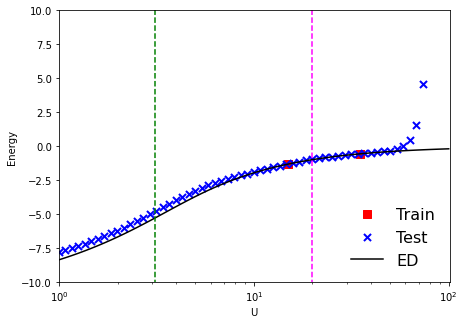

In [14]:
# plt.rcParams.update({'font.size': 20})
# plt.rc('text',usetex=True)
# #font = {'family':'serif','size':16}
# font = {'family':'serif','size':25, 'serif': ['computer modern roman']}
# plt.rc('font',**font)
# matplotlib.rcParams['text.latex.preamble']=[r'\usepackage{amsmath}']
ymini=-10.0
#ymini=-15.0
#ymini=-7.5
ymaxi=10.0
#ymini=-12.0
#ymaxi=100.0
fig, ax = plt.subplots(figsize=(7,5))
ax.scatter(U_train,E_train,s=50,c='r', marker='s',label='Train')
ax.scatter(U_test,E_test,s=50, c='b', marker='x',label='Test',lw=2)

arr = [] 
for (i, U) in enumerate(U_test):
    _, _, H = model.H_Bose_Hubbard(t, U, V=V, mu=mu_train[0])
    vals, vecs = np.linalg.eig(H)
    vals_idx = np.argsort(vals)
    vals = np.sort(vals)
    arr.append(vals[0])
ax.plot(U_test,arr,'k',label='ED')
#ax.set_xlim([min(U_test), max(U_test)])  
ax.set_ylabel('Energy')
ax.set_xlabel('U')
plt.legend(frameon=False,prop={'size': 16})
ax.set_xscale("log")
ax.axvline(x=3.12,ymin=ymini,ymax=ymaxi,c="green",linestyle='dashed')
ax.axvline(x=20,ymin=ymini,ymax=ymaxi,c="magenta",linestyle='dashed')
#ax.set_yscale("log")
#ax.set_ylim(np.log(0.0001),np.log(1000))
#ax.set_xlim(0.001,1000)
#plt.xlim(0.001,21)
plt.xlim(1,101)
#plt.xlim(0.01,101)
plt.ylim(ymini,ymaxi)
#plt.savefig("./figures/scaling/energy_M{}N{}Utrain{}lr{}-adam.pdf".format(M,N,U_train,lr), format='pdf',bbox_inches='tight')
plt.savefig("./figures/scaling/energy_M{}N{}Utrain{}lr{}.pdf".format(M,N,U_train,lr), format='pdf',bbox_inches='tight')
plt.show()



/tmp/ipykernel_3028942/2487725548.py:1: ComplexWarning: Casting complex values to real discards the imaginary part
  mini=int(min([min(E_train),min(E_test),min(arr)]))


-8
[-1.30180478]
[-7.76771736]
(-8.366991700815396+0j)


/software/easybuild/software/matplotlib/3.5.2-foss-2022a/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/software/easybuild/software/matplotlib/3.5.2-foss-2022a/lib/python3.10/site-packages/matplotlib/transforms.py:2877: ComplexWarning: Casting complex values to real discards the imaginary part
  vmin, vmax = map(float, [vmin, vmax])


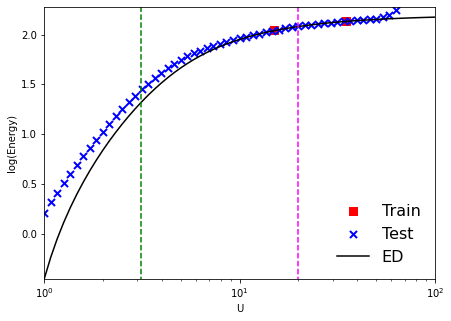

In [15]:
mini=int(min([min(E_train),min(E_test),min(arr)]))
print(mini)
fig, ax = plt.subplots(figsize=(7,5))
#mini_train=int(min(E_train))
print(min(E_train))
#mini_test=int(min(E_test))
print(min(E_test))
logE_train=[]
logE_test=[]
for i in range (len(E_train)):
    logE_train.append(np.log(E_train[i]-mini+1))
for i in range (len(E_test)):
    logE_test.append(np.log(E_test[i]-mini+1))
ax.scatter(U_train,logE_train,s=50,c='r', marker='s',label='Train')
ax.scatter(U_test,logE_test,s=50, c='b', marker='x',label='Test',lw=2)

arr = [] 
logarr=[]
for (i, U) in enumerate(U_test):
    _, _, H = model.H_Bose_Hubbard(t, U, V=V, mu=mu_train[0])
    vals, vecs = np.linalg.eig(H)
    vals_idx = np.argsort(vals)
    vals = np.sort(vals)
    arr.append(vals[0])
#mini_arr=int(min(arr))
print(min(arr))
for i in range (len(arr)):
    logarr.append(np.log(arr[i]-mini+1))
ax.plot(U_test,logarr,'k',label='ED')
ax.set_xlim([min(U_test), max(U_test)]) 
#ax.set_ylim(0,6)
#ax.set_ylim(-10,6)
ax.set_ylim([min(logarr), max(logarr)+0.1])
ax.set_ylabel('log(Energy)')
ax.set_xlabel('U')
plt.legend(frameon=False,prop={'size': 16})
ax.set_xscale("log")
ax.axvline(x=3.12,ymin=ymini,ymax=ymaxi,c="green",linestyle='dashed')
ax.axvline(x=20,ymin=ymini,ymax=ymaxi,c="magenta",linestyle='dashed')
#ax.set_yscale("log")
#ax.set_ylim(np.log(0.0001),np.log(1000))
#ax.set_xlim(0.001,1000)
#plt.savefig("./figures/scaling/energy_M{}N{}Utrain{}lr{}-log-adam.pdf".format(M,N,U_train,lr), format='pdf',bbox_inches='tight')
plt.savefig("./figures/scaling/energy_M{}N{}Utrain{}lr{}-log.pdf".format(M,N,U_train,lr), format='pdf',bbox_inches='tight')
plt.show()



# Reading ground state enerrgy VS U from files

In [25]:
U_test

array([7.49894209e-03, 8.65964323e-03, 1.00000000e-02, 1.15478198e-02,
       1.33352143e-02, 1.53992653e-02, 1.77827941e-02, 2.05352503e-02,
       2.37137371e-02, 2.73841963e-02, 3.16227766e-02, 3.65174127e-02,
       4.21696503e-02, 4.86967525e-02, 5.62341325e-02, 6.49381632e-02,
       7.49894209e-02, 8.65964323e-02, 1.00000000e-01, 1.15478198e-01,
       1.33352143e-01, 1.53992653e-01, 1.77827941e-01, 2.05352503e-01,
       2.37137371e-01, 2.73841963e-01, 3.16227766e-01, 3.65174127e-01,
       4.21696503e-01, 4.86967525e-01, 5.62341325e-01, 6.49381632e-01,
       7.49894209e-01, 8.65964323e-01, 1.00000000e+00, 1.15478198e+00,
       1.33352143e+00, 1.53992653e+00, 1.77827941e+00, 2.05352503e+00,
       2.37137371e+00, 2.73841963e+00, 3.16227766e+00, 3.65174127e+00,
       4.21696503e+00, 4.86967525e+00, 5.62341325e+00, 6.49381632e+00,
       7.49894209e+00, 8.65964323e+00, 1.00000000e+01, 1.15478198e+01,
       1.33352143e+01, 1.53992653e+01, 1.77827941e+01, 2.05352503e+01,
      

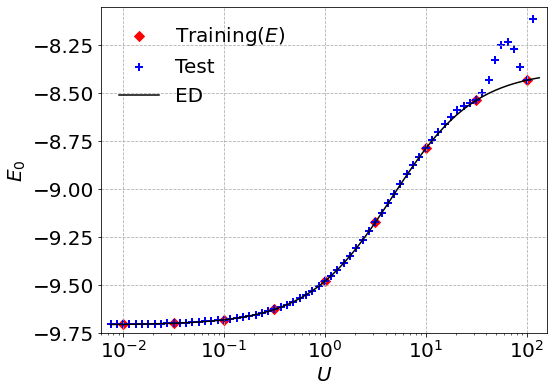

In [5]:
fig, ax1 = plt.subplots(figsize=(8, 6))
fig.subplots_adjust(hspace=0)
import pandas as pd
#fig, ax = plt.subplots(figsize=(7,5))
#cc=0
a=pd.read_csv(f'./2D-E_gs/2D-ADAM-M-{M}-N-{N}-U_train-{U_train}-lr{lr}-w{w}-h{h}.csv',header=None)
bb=pd.DataFrame(a)

E_train=[]

for i in range (len(bb)):
    c=bb.iloc[i]
    
    E_train.append(float(c[0][25:]))
    
a=pd.read_csv(f'./2D-E_gs/2D-ADAM-M-{M}-N-{N}-U_test-{U_train}-lr{lr}-w{w}-h{h}.csv',header=None)
#a=pd.read_csv(f'./E_gs/M-{M}-N-{N}-U_test-{U_train}-lr{lr}-adam.csv',header=None)
bb=pd.DataFrame(a)
U_test=[]
E_test=[]
for i in range (len(bb)):
    c=bb.iloc[i]
    #print(c[0])
    U_test.append(float(c[0][:25]))
    E_test.append(float(c[0][25:]))
    

ax1.scatter(U_train,E_train,s=50,c='r', marker="D",label='Training($E$)')
ax1.scatter(U_test,E_test,s=50, c='b', marker='+',label='Test',lw=2)


a=pd.read_csv(f'./2D-E_gs_exact/M-{M}-N-{N}-w-{w}-h{h}-U_test.csv',header=None)
bb=pd.DataFrame(a)

arr=[]


for i in range (len(bb)):
    c=bb.iloc[i]
    
    arr.append(float(c[0][25:]))
#print(min(arr))

a=pd.read_csv(f'./2D-E_gs_exact/M-{M}-N-{N}-w-{w}-h{h}-U_train.csv',header=None)
bb=pd.DataFrame(a)

arr1=[]


for i in range (len(bb)):
    c=bb.iloc[i]
    
    arr1.append(float(c[0][25:]))



ax1.plot(U_test,arr,'k',label='ED')
# ax2.scatter(U_train,np.abs(np.array(arr1)-np.array(E_train)),c='r', marker='s',s=100,label='Train')
# ax2.scatter(U_test,np.abs(np.array(arr)-np.array(E_test)), c='b', marker='x',s=100,lw=2,label='Test')
# ax3.scatter(U_train,(np.abs(np.array(arr1)-np.array(E_train)))/np.abs(np.array(arr1)),c='r', marker='s',s=100,label='Train')
# ax3.scatter(U_test,(np.abs(np.array(arr)-np.array(E_test)))/np.abs(np.array(arr)), c='b', marker='x',s=100,lw=2,label='Test')





#ax1.set_ylabel('Energy')
#ax1.set_xlabel(r'$U$')
ax1.legend(frameon=False,prop={'size': 20})
#ax2.legend(frameon=False,prop={'size': 20})
ax1.set_xscale("log")
# ax2.set_yscale("log")
# ax3.set_yscale("log")
ax1.set_xlim(0.006,160)

ax1.set_ylim(-9.75,-8.05)
#ax2.set_ylim(0.001,0.15)
ax1.set_ylabel(r'$E_0$',fontsize=20)
# ax2.set_ylabel(r'$|\Delta$ $E_0|$',fontsize=20)
ax1.set_xlabel(r'$U$',fontsize=20)
# ax3.set_ylabel(r'$|\Delta$ $E_0$/$E_0|$ ',fontsize=20)
# ax3.set_xlabel(r'$U$',fontsize=20)
#plt.legend(frameon=False,prop={'size': 20})

#ax1.set_xticks(ticks=np.logspace(-2,2,5),fontsize=20)
plt.xticks(fontsize=20)
#ax1.set_yticks(np.linspace(-12,0,7),fontsize=20)
#ax1.set_yticklabels(['-12','-10','-8','-6','-4','-2','0'],fontsize=20)
#plt.yticks(fontsize=20)
ax1.tick_params(axis='both', which='major', labelsize=20)
# ax2.tick_params(axis='both', which='major', labelsize=20)
# ax3.tick_params(axis='both', which='major', labelsize=20)
plt.yticks(fontsize=20)
ax1.grid(linestyle='dashed')
# ax2.grid(linestyle='dashed')
# ax3.grid(linestyle='dashed')

#plt.savefig("./regensburg/energy_M{}N{}Utrain{}lr{}cc{}-adam.pdf".format(M,N,U_train,lr,cc), format='pdf',bbox_inches='tight',dpi=1000)
#plt.show()
fig.savefig(f"./paper-2D-ground-state/2D-ground-state-energy-E0-M-{M}-N-{N}-w-{w}-h-{h}.pdf",bbox_inches='tight',dpi=1000)

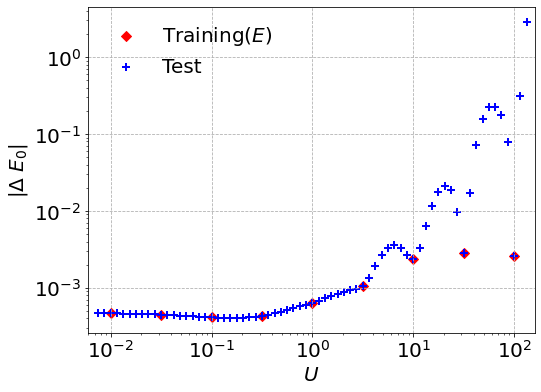

In [6]:
fig, ax2 = plt.subplots(figsize=(8, 6))
fig.subplots_adjust(hspace=0)
import pandas as pd
#fig, ax = plt.subplots(figsize=(7,5))
#cc=0
a=pd.read_csv(f'./2D-E_gs/2D-ADAM-M-{M}-N-{N}-U_train-{U_train}-lr{lr}-w{w}-h{h}.csv',header=None)
bb=pd.DataFrame(a)

E_train=[]

for i in range (len(bb)):
    c=bb.iloc[i]
    
    E_train.append(float(c[0][25:]))
    
a=pd.read_csv(f'./2D-E_gs/2D-ADAM-M-{M}-N-{N}-U_test-{U_train}-lr{lr}-w{w}-h{h}.csv',header=None)
#a=pd.read_csv(f'./E_gs/M-{M}-N-{N}-U_test-{U_train}-lr{lr}-adam.csv',header=None)
bb=pd.DataFrame(a)
U_test=[]
E_test=[]
for i in range (len(bb)):
    c=bb.iloc[i]
    #print(c[0])
    U_test.append(float(c[0][:25]))
    E_test.append(float(c[0][25:]))
    

# ax1.scatter(U_train,E_train,s=100,c='r', marker='s',label='Train')
# ax1.scatter(U_test,E_test,s=100, c='b', marker='x',label='Test',lw=2)


a=pd.read_csv(f'./2D-E_gs_exact/M-{M}-N-{N}-w-{w}-h{h}-U_test.csv',header=None)
bb=pd.DataFrame(a)

arr=[]


for i in range (len(bb)):
    c=bb.iloc[i]
    
    arr.append(float(c[0][25:]))
#print(min(arr))

a=pd.read_csv(f'./2D-E_gs_exact/M-{M}-N-{N}-w-{w}-h{h}-U_train.csv',header=None)
bb=pd.DataFrame(a)

arr1=[]


for i in range (len(bb)):
    c=bb.iloc[i]
    
    arr1.append(float(c[0][25:]))



# ax1.plot(U_test,arr,'k',label='ED')
ax2.scatter(U_train,np.abs(np.array(arr1)-np.array(E_train)),c='r', marker='D',s=50,label='Training($E$)')
ax2.scatter(U_test,np.abs(np.array(arr)-np.array(E_test)), c='b', marker='+',s=50,lw=2,label='Test')
# ax3.scatter(U_train,(np.abs(np.array(arr1)-np.array(E_train)))/np.abs(np.array(arr1)),c='r', marker='s',s=100,label='Train')
# ax3.scatter(U_test,(np.abs(np.array(arr)-np.array(E_test)))/np.abs(np.array(arr)), c='b', marker='x',s=100,lw=2,label='Test')





#ax1.set_ylabel('Energy')
#ax1.set_xlabel(r'$U$')
ax2.legend(frameon=False,prop={'size': 20},loc='upper left')
#ax2.legend(frameon=False,prop={'size': 20})
ax2.set_xscale("log")
ax2.set_yscale("log")
# ax3.set_yscale("log")
ax2.set_xlim(0.006,160)

#ax1.set_ylim(-9.75,-8.1)
#ax2.set_ylim(0.001,0.15)
# ax1.set_ylabel(r'$E_0$',fontsize=20)
ax2.set_ylabel(r'$|\Delta$ $E_0|$',fontsize=20)
ax2.set_xlabel(r'$U$',fontsize=20)
# ax3.set_ylabel(r'$|\Delta$ $E_0$/$E_0|$ ',fontsize=20)
# ax3.set_xlabel(r'$U$',fontsize=20)
#plt.legend(frameon=False,prop={'size': 20})

#ax1.set_xticks(ticks=np.logspace(-2,2,5),fontsize=20)
plt.xticks(fontsize=20)
#ax1.set_yticks(np.linspace(-12,0,7),fontsize=20)
#ax1.set_yticklabels(['-12','-10','-8','-6','-4','-2','0'],fontsize=20)
#plt.yticks(fontsize=20)
# ax1.tick_params(axis='both', which='major', labelsize=20)
ax2.tick_params(axis='both', which='major', labelsize=20)
# ax3.tick_params(axis='both', which='major', labelsize=20)
plt.yticks(fontsize=20)
# ax1.grid(linestyle='dashed')
ax2.grid(linestyle='dashed')
# ax3.grid(linestyle='dashed')

#plt.savefig("./regensburg/energy_M{}N{}Utrain{}lr{}cc{}-adam.pdf".format(M,N,U_train,lr,cc), format='pdf',bbox_inches='tight',dpi=1000)
#plt.show()
fig.savefig(f"./paper-2D-ground-state/2D-ground-state-energy-deltaE0-M-{M}-N-{N}-w-{w}-h-{h}.pdf",bbox_inches='tight',dpi=1000)

/software/easybuild/software/SciPy-bundle/2022.05-foss-2022.05/lib/python3.10/site-packages/numpy/ma/core.py:6852: RuntimeWarning: overflow encountered in power
  result = np.where(m, fa, umath.power(fa, fb)).view(basetype)


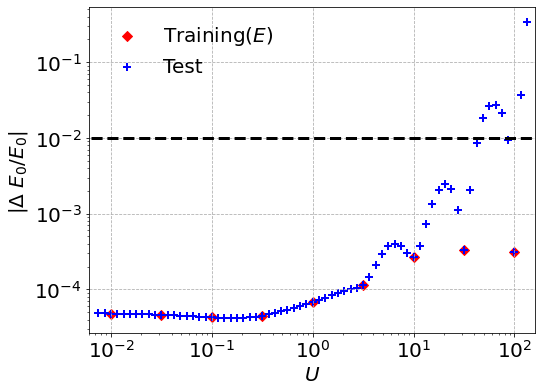

In [7]:
fig, ax3 = plt.subplots(figsize=(8, 6))
fig.subplots_adjust(hspace=0)
import pandas as pd
#fig, ax = plt.subplots(figsize=(7,5))
#cc=0
a=pd.read_csv(f'./2D-E_gs/2D-ADAM-M-{M}-N-{N}-U_train-{U_train}-lr{lr}-w{w}-h{h}.csv',header=None)
bb=pd.DataFrame(a)

E_train=[]

for i in range (len(bb)):
    c=bb.iloc[i]
    
    E_train.append(float(c[0][25:]))
    
a=pd.read_csv(f'./2D-E_gs/2D-ADAM-M-{M}-N-{N}-U_test-{U_train}-lr{lr}-w{w}-h{h}.csv',header=None)
#a=pd.read_csv(f'./E_gs/M-{M}-N-{N}-U_test-{U_train}-lr{lr}-adam.csv',header=None)
bb=pd.DataFrame(a)
U_test=[]
E_test=[]
for i in range (len(bb)):
    c=bb.iloc[i]
    #print(c[0])
    U_test.append(float(c[0][:25]))
    E_test.append(float(c[0][25:]))
    

# ax1.scatter(U_train,E_train,s=100,c='r', marker='s',label='Train')
# ax1.scatter(U_test,E_test,s=100, c='b', marker='x',label='Test',lw=2)


a=pd.read_csv(f'./2D-E_gs_exact/M-{M}-N-{N}-w-{w}-h{h}-U_test.csv',header=None)
bb=pd.DataFrame(a)

arr=[]


for i in range (len(bb)):
    c=bb.iloc[i]
    
    arr.append(float(c[0][25:]))
#print(min(arr))

a=pd.read_csv(f'./2D-E_gs_exact/M-{M}-N-{N}-w-{w}-h{h}-U_train.csv',header=None)
bb=pd.DataFrame(a)

arr1=[]


for i in range (len(bb)):
    c=bb.iloc[i]
    
    arr1.append(float(c[0][25:]))



# ax1.plot(U_test,arr,'k',label='ED')
# ax2.scatter(U_train,np.abs(np.array(arr1)-np.array(E_train)),c='r', marker='s',s=100,label='Train')
# ax2.scatter(U_test,np.abs(np.array(arr)-np.array(E_test)), c='b', marker='x',s=100,lw=2,label='Test')
ax3.scatter(U_train,(np.abs(np.array(arr1)-np.array(E_train)))/np.abs(np.array(arr1)),c='r', marker='D',s=50,label='Training($E$)')
ax3.scatter(U_test,(np.abs(np.array(arr)-np.array(E_test)))/np.abs(np.array(arr)), c='b', marker='+',s=50,lw=2,label='Test')





#ax1.set_ylabel('Energy')
#ax1.set_xlabel(r'$U$')
ax3.legend(frameon=False,prop={'size': 20},loc='upper left')
#ax2.legend(frameon=False,prop={'size': 20})
ax3.set_xscale("log")
# ax2.set_yscale("log")
ax3.set_yscale("log")
ax3.set_xlim(0.006,160)


ax3.axhline(y=0.01,xmin=0.006,xmax=160,c="black",linestyle='dashed',lw=3)
# ax1.set_ylim(-9.75,-8.1)
#ax2.set_ylim(0.001,0.15)
# ax1.set_ylabel(r'$E_0$',fontsize=20)
# ax2.set_ylabel(r'$|\Delta$ $E_0|$',fontsize=20)
# ax2.set_xlabel(r'$U$',fontsize=20)
ax3.set_ylabel(r'$|\Delta$ $E_0$/$E_0|$ ',fontsize=20)
ax3.set_xlabel(r'$U$',fontsize=20)
#plt.legend(frameon=False,prop={'size': 20})

#ax1.set_xticks(ticks=np.logspace(-2,2,5),fontsize=20)
plt.xticks(fontsize=20)
#ax1.set_yticks(np.linspace(-12,0,7),fontsize=20)
#ax1.set_yticklabels(['-12','-10','-8','-6','-4','-2','0'],fontsize=20)
#plt.yticks(fontsize=20)
# ax1.tick_params(axis='both', which='major', labelsize=20)
# ax2.tick_params(axis='both', which='major', labelsize=20)
ax3.tick_params(axis='both', which='major', labelsize=20)
plt.yticks(fontsize=20)
# ax1.grid(linestyle='dashed')
# ax2.grid(linestyle='dashed')
ax3.grid(linestyle='dashed')

#plt.savefig("./regensburg/energy_M{}N{}Utrain{}lr{}cc{}-adam.pdf".format(M,N,U_train,lr,cc), format='pdf',bbox_inches='tight',dpi=1000)
#plt.show()
fig.savefig(f"./paper-2D-ground-state/2D-ground-state-energy-deltaE0E0-M-{M}-N-{N}-w-{w}-h-{h}.pdf",bbox_inches='tight',dpi=1000)

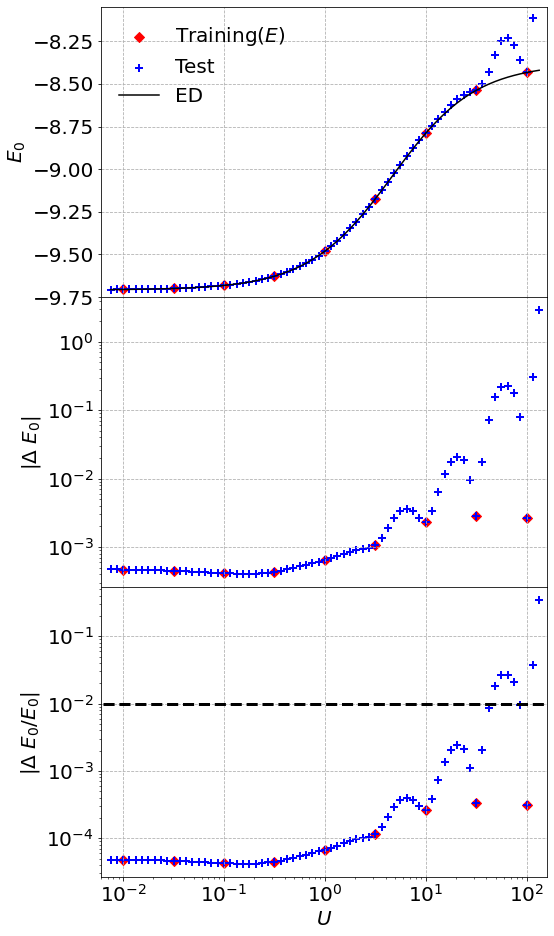

In [9]:
fig, (ax1,ax2,ax3) = plt.subplots(3,1,figsize=(8, 16), sharex=True)
fig.subplots_adjust(hspace=0)
import pandas as pd
#fig, ax = plt.subplots(figsize=(7,5))
#cc=0
a=pd.read_csv(f'./2D-E_gs/2D-ADAM-M-{M}-N-{N}-U_train-{U_train}-lr{lr}-w{w}-h{h}.csv',header=None)
bb=pd.DataFrame(a)

E_train=[]

for i in range (len(bb)):
    c=bb.iloc[i]
    
    E_train.append(float(c[0][25:]))
    
a=pd.read_csv(f'./2D-E_gs/2D-ADAM-M-{M}-N-{N}-U_test-{U_train}-lr{lr}-w{w}-h{h}.csv',header=None)
#a=pd.read_csv(f'./E_gs/M-{M}-N-{N}-U_test-{U_train}-lr{lr}-adam.csv',header=None)
bb=pd.DataFrame(a)
U_test=[]
E_test=[]
for i in range (len(bb)):
    c=bb.iloc[i]
    #print(c[0])
    U_test.append(float(c[0][:25]))
    E_test.append(float(c[0][25:]))
    

ax1.scatter(U_train,E_train,s=50,c='r', marker='D',label='Training($E$)')
ax1.scatter(U_test,E_test,s=50, c='b', marker='+',label='Test',lw=2)


a=pd.read_csv(f'./2D-E_gs_exact/M-{M}-N-{N}-w-{w}-h{h}-U_test.csv',header=None)
bb=pd.DataFrame(a)

arr=[]


for i in range (len(bb)):
    c=bb.iloc[i]
    
    arr.append(float(c[0][25:]))
#print(min(arr))

a=pd.read_csv(f'./2D-E_gs_exact/M-{M}-N-{N}-w-{w}-h{h}-U_train.csv',header=None)
bb=pd.DataFrame(a)

arr1=[]


for i in range (len(bb)):
    c=bb.iloc[i]
    
    arr1.append(float(c[0][25:]))



ax1.plot(U_test,arr,'k',label='ED')
ax2.scatter(U_train,np.abs(np.array(arr1)-np.array(E_train)),c='r', marker='D',s=50,label='Training($E$)')
ax2.scatter(U_test,np.abs(np.array(arr)-np.array(E_test)), c='b', marker='+',s=50,lw=2,label='Test')
ax3.scatter(U_train,(np.abs(np.array(arr1)-np.array(E_train)))/np.abs(np.array(arr1)),c='r', marker='D',s=50,label='Training(E)')
ax3.scatter(U_test,(np.abs(np.array(arr)-np.array(E_test)))/np.abs(np.array(arr)), c='b', marker='+',s=50,lw=2,label='Test')
ax3.axhline(y=0.01,xmin=0.006,xmax=160,c="black",linestyle='dashed',lw=3)




#ax1.set_ylabel('Energy')
#ax1.set_xlabel(r'$U$')
ax1.legend(frameon=False,prop={'size': 20})
#ax2.legend(frameon=False,prop={'size': 20})
ax1.set_xscale("log")
ax2.set_yscale("log")
ax3.set_yscale("log")
ax1.set_xlim(0.006,160)

ax1.set_ylim(-9.75,-8.05)
#ax2.set_ylim(0.001,0.15)
ax1.set_ylabel(r'$E_0$',fontsize=20)
ax2.set_ylabel(r'$|\Delta$ $E_0|$',fontsize=20)
ax2.set_xlabel(r'$U$',fontsize=20)
ax3.set_ylabel(r'$|\Delta$ $E_0$/$E_0|$ ',fontsize=20)
ax3.set_xlabel(r'$U$',fontsize=20)
#plt.legend(frameon=False,prop={'size': 20})

#ax1.set_xticks(ticks=np.logspace(-2,2,5),fontsize=20)
plt.xticks(fontsize=20)
#ax1.set_yticks(np.linspace(-12,0,7),fontsize=20)
#ax1.set_yticklabels(['-12','-10','-8','-6','-4','-2','0'],fontsize=20)
#plt.yticks(fontsize=20)
ax1.tick_params(axis='both', which='major', labelsize=20)
ax2.tick_params(axis='both', which='major', labelsize=20)
ax3.tick_params(axis='both', which='major', labelsize=20)
plt.yticks(fontsize=20)
ax1.grid(linestyle='dashed')
ax2.grid(linestyle='dashed')
ax3.grid(linestyle='dashed')

#plt.savefig("./regensburg/energy_M{}N{}Utrain{}lr{}cc{}-adam.pdf".format(M,N,U_train,lr,cc), format='pdf',bbox_inches='tight',dpi=1000)
#plt.show()
fig.savefig(f"./paper-2D-ground-state/2D-ground-state-energy-M-{M}-N-{N}-w-{w}-h-{h}.pdf",bbox_inches='tight',dpi=1000)

/tmp/ipykernel_3133050/2061408447.py:27: ComplexWarning: Casting complex values to real discards the imaginary part
  vals_all[:,i] = vals
/tmp/ipykernel_3133050/2061408447.py:28: ComplexWarning: Casting complex values to real discards the imaginary part
  vecs_all[:,:,i] = vecs


0


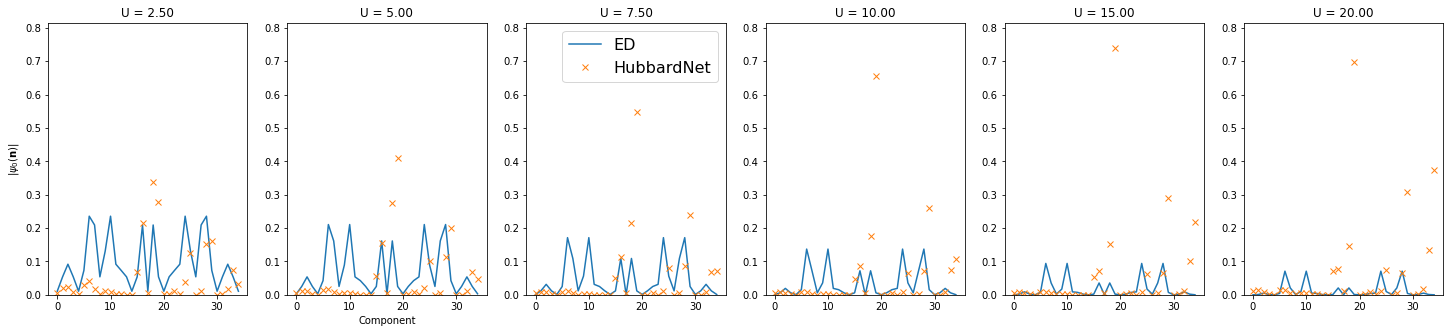

In [107]:
# rearrange states by symmetry 
all_states = np.zeros_like(model.all_states)
idx_list = np.zeros(model.tot_states,dtype=int)

for i in range(int(model.tot_states/2)): 
    all_states[i] = model.all_states[i]
    all_states[-i-1] = np.flip(model.all_states[i])
    idx_list[i] = i
    for j in range(model.tot_states):
        if all(model.all_states[j]==all_states[-i-1]): 
            idx_list[-i-1] = j
            break

# check wavefunctions 
U_test = np.array( [2.5, 5, 7.5,10,15,20] ) 
#U_test = np.array( [ 7.5,15,20] ) 
mu_test = np.zeros(len(U_test))
vals_all = np.zeros((model.tot_states, len(U_test)))
vals_idx_all = np.zeros_like(vals_all)
vecs_all = np.zeros((model.tot_states, model.tot_states, len(U_test)))

for (i,U) in enumerate(U_test):
    
    _, _, H = model.H_Bose_Hubbard(t, U, mu=mu_train[0])
    vals, vecs = np.linalg.eig(H)
    vals_idx_all[:,i] = np.argsort(vals)
    vals_all[:,i] = vals
    vecs_all[:,:,i] = vecs

E_test, wf_test = wf_e_calc(model_list[0], N_list[0], U_test, mu_test, t, V, 0, 0, fc1, use_gpu=True)


for s in range(0,max_state): 
    print(s)
    fig, ax = plt.subplots(1, len(U_test), figsize=(25, 5)) # for paper, figsize (20, 5) for 1D (25, 5) for 2D
    
    ymax = torch.max(wf_test[:,s]).detach().cpu().numpy()*1.1
    ymin = 0
    n_list = np.zeros( (len(U_test),M) )

    for (i,U) in enumerate(U_test):
    
        wf_here = wf_test[i*model.tot_states:(i+1)*model.tot_states,s].squeeze().double()

        # calculate occupation numbers
        for m_idx in range(M):
            for state_idx in range(model.tot_states):
                ci = wf_here[state_idx].cpu().detach().numpy()
                ni = model.all_states[state_idx][m_idx]
                n_list[i,m_idx] += ci**2 * ni

        wf_exact = np.abs(vecs_all[:,int(vals_idx_all[s, i]), i]).squeeze()
        wf_nn = np.abs(wf_here.cpu().detach().numpy())
        ax[i].plot(wf_exact[idx_list], label="ED")
        ax[i].plot(wf_nn[idx_list], 'x', label="HubbardNet")
        
        ax[i].set_title("U = {0:.2f}".format(U))
        ax[i].set_ylim((ymin,ymax))
    ax[0].set_ylabel('$|\psi_0 (\mathbf{n})|$')
    # ax[0].set_xlabel('Component')
    ax[1].set_xlabel('Component')
    ax[2].legend(frameon=True, prop={'size': 16})
    plt.savefig("./figures/wf_M{}N{}_n{}_nexcited_{}.pdf".format(M,N,s,n_excited), format='pdf',bbox_inches='tight')
    plt.show()
    




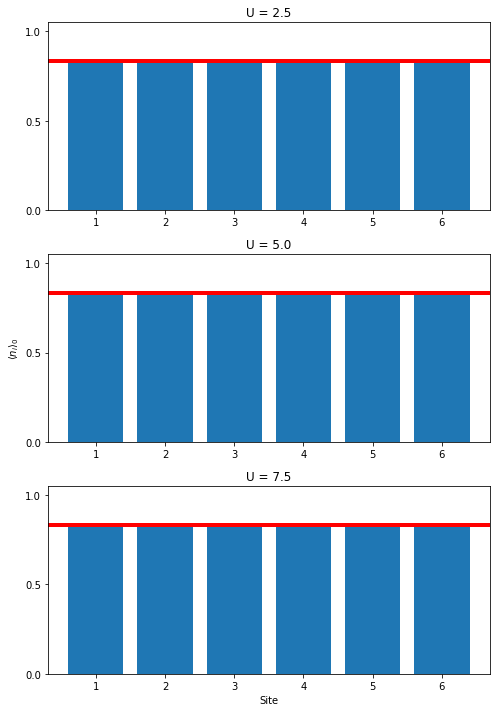

In [13]:
xgrid, ygrid = np.meshgrid(np.arange(w)+1, np.arange(h)+1)
xgrid = xgrid.ravel()
ygrid = ygrid.ravel()

if h == 1: # 1D
    fig, ax = plt.subplots(len(U_test),1,figsize=(7,10))
    for i, U in enumerate(U_test): 
        ax[i].bar(xgrid,n_list[i,:])
        ax[i].set_title("U = {0:.1f}".format(U))
        ax[i].set_xticks(xgrid)
        ax[i].axhline( N/M, linewidth=4, color='r', linestyle='-')
        ax[i].set_ylim([0,1.05])
        ax[i].set_yticks([0,0.5,1])

    ax[i].set_xlabel('Site')
    ax[1].set_ylabel(r'$ \langle n_i \rangle_0 $')
    plt.tight_layout()

else: # 2D 
    idx=2
    fig, ax = plt.subplots(figsize=(7,7))
    im=plt.pcolormesh(np.reshape(n_list[idx,:],(h,w)),cmap='coolwarm')
    ax.grid(True, color="k", lw=1)
    cbar=plt.colorbar(im,fraction=0.046, pad=0.04)
    cbar.set_label(r'$\langle n_i \rangle_0 $')
    ax.set_aspect('equal')
    plt.xlabel('$x$')
    plt.ylabel('$y$')
    plt.xticks(np.arange(w))
    plt.yticks(np.arange(h))
    plt.title('$U = {}$'.format(U_test[idx]))
    plt.tight_layout()
      
plt.savefig("./figures/occupation_M{}N{}U{}.pdf".format(M,N,U), format='pdf',bbox_inches='tight')
plt.show()


# Overlap between the wavefunctions of ED  and testing

In [119]:
# rearrange states by symmetry 
all_states = np.zeros_like(model.all_states)
idx_list = np.zeros(model.tot_states,dtype=int)

for i in range(int(model.tot_states/2)): 
    all_states[i] = model.all_states[i]
    all_states[-i-1] = np.flip(model.all_states[i])
    idx_list[i] = i
    for j in range(model.tot_states):
        if all(model.all_states[j]==all_states[-i-1]): 
            idx_list[-i-1] = j
            break

# check wavefunctions 
#U_test = np.array( [2.5, 5, 7.5,10,15,20] ) 
U_test = np.logspace(0, 2, 61, endpoint = True)
#U_test = np.array( [ 7.5,15,20] ) 
mu_test = np.zeros(len(U_test))
vals_all = np.zeros((model.tot_states, len(U_test)))
vals_idx_all = np.zeros_like(vals_all)
vecs_all = np.zeros((model.tot_states, model.tot_states, len(U_test)))

for (i,U) in enumerate(U_test):
    
    _, _, H = model.H_Bose_Hubbard(t, U, mu=mu_train[0])
    vals, vecs = np.linalg.eig(H)
    vals_idx_all[:,i] = np.argsort(vals)
    vals_all[:,i] = vals
    vecs_all[:,:,i] = vecs

E_test, wf_test = wf_e_calc(model_list[0], N_list[0], U_test, mu_test, t, V, 0, 0, fc1, use_gpu=True)


for s in range(0,max_state): 
    print(s)
    #fig, ax = plt.subplots(1, len(U_test), figsize=(25, 5)) # for paper, figsize (20, 5) for 1D (25, 5) for 2D
    
    ymax = torch.max(wf_test[:,s]).detach().cpu().numpy()*1.1
    ymin = 0
    n_list = np.zeros( (len(U_test),M) )
    
    overlap=[]
    for (i,U) in enumerate(U_test):
    
        wf_here = wf_test[i*model.tot_states:(i+1)*model.tot_states,s].squeeze().double()

        # calculate occupation numbers
        for m_idx in range(M):
            for state_idx in range(model.tot_states):
                ci = wf_here[state_idx].cpu().detach().numpy()
                ni = model.all_states[state_idx][m_idx]
                n_list[i,m_idx] += ci**2 * ni

        wf_exact = np.abs(vecs_all[:,int(vals_idx_all[s, i]), i]).squeeze()
        wf_nn = np.abs(wf_here.cpu().detach().numpy())
        #ax[i].plot(wf_exact[idx_list], label="ED")
        #ax[i].plot(wf_nn[idx_list], 'x', label="HubbardNet")
        overlap.append(np.dot(wf_exact[idx_list],wf_nn[idx_list]))
        #ax[i].set_title("U = {0:.2f}".format(U))
        #ax[i].set_ylim((ymin,ymax))
#     ax.plot(U_test,overlap)
#     ax[0].set_ylabel('overlap')
#     # ax[0].set_xlabel('Component')
#     ax[0].set_xlabel('U')
#     #ax[0].legend(frameon=True, prop={'size': 16})
#     #plt.savefig("./figures/wf_M{}N{}_n{}_nexcited_{}.pdf".format(M,N,s,n_excited), format='pdf',bbox_inches='tight')
#     plt.show()
    
# plt.plot(U_test,overlap,'.-')
# plt.xscale("log")
# plt.xlabel('U')
# plt.ylabel('overlap')
# plt.show()



/tmp/ipykernel_3133050/1788487952.py:28: ComplexWarning: Casting complex values to real discards the imaginary part
  vals_all[:,i] = vals
/tmp/ipykernel_3133050/1788487952.py:29: ComplexWarning: Casting complex values to real discards the imaginary part
  vecs_all[:,:,i] = vecs


0


In [114]:
# plt.plot(U_test,overlap,'.-')
# plt.xscale("log")
# plt.xlabel('U')
# plt.ylabel('overlap')
# plt.show()

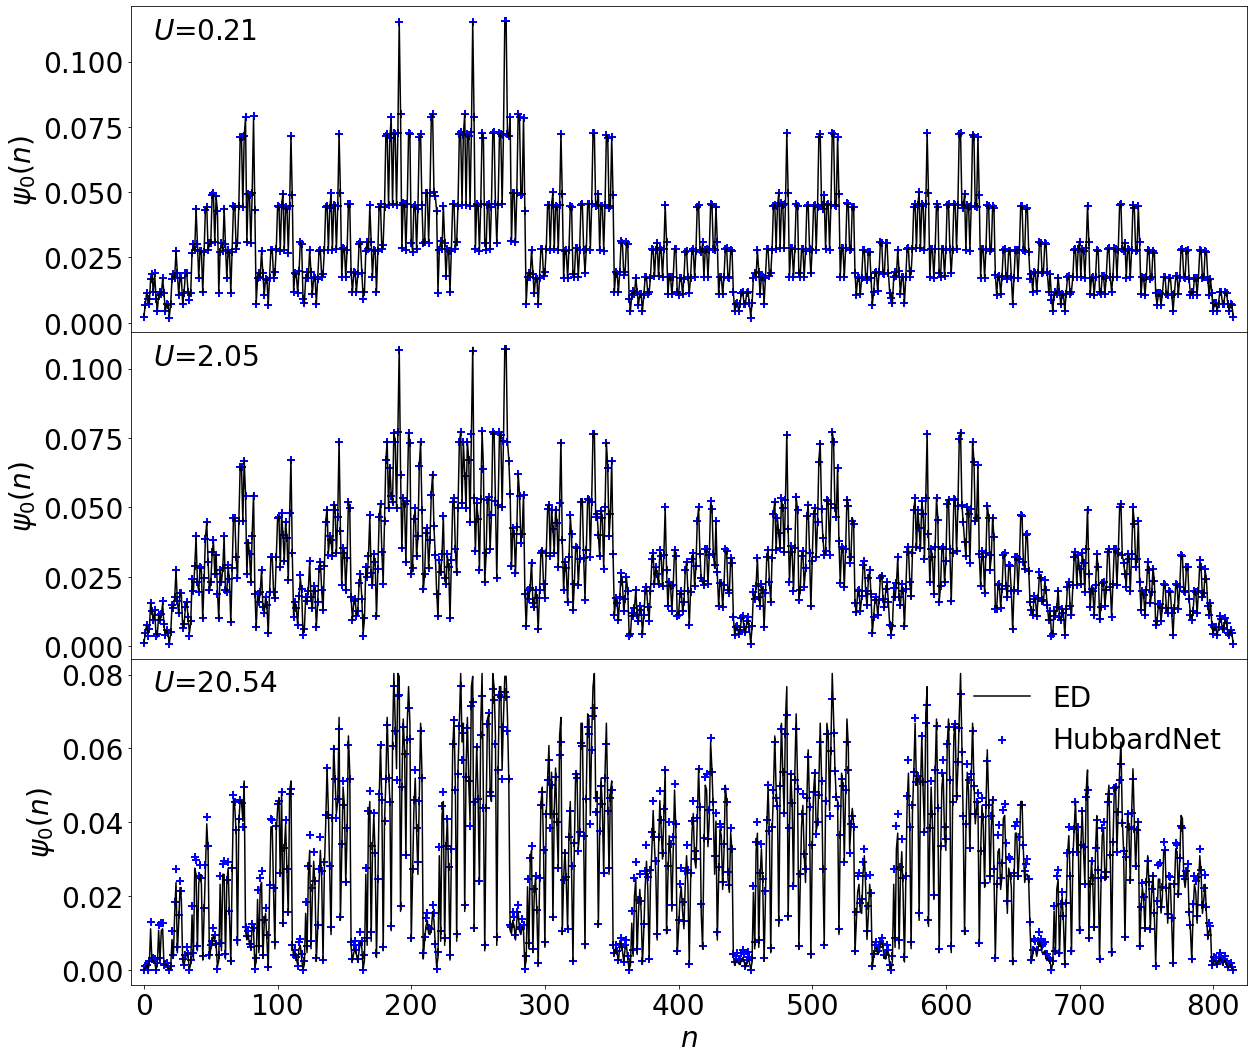

In [19]:
U_test = np.logspace(-2.125, 2.125, 69, endpoint = True)
fig,ax = plt.subplots(3,1,figsize=(20, 18), sharex=True)
fig.subplots_adjust(hspace=0)
for (i,U) in enumerate([0.2053525026457146,2.0535250264571463,20.53525026457146]):
    
    wf_nn=np.genfromtxt(f'./2D-states/2D-ADAM-M-{M}-N-{N}-U_test-{U_train}-lr-{lr}-w{w}-h{h}/U_test-{U}.csv')
    #wf_nn1=np.genfromtxt(f'./states/M-{M}-N-{N}-U_test-{U_train}-lr-{lr}/U_test-{U}.csv')
    wf_exact=np.genfromtxt(f'./2D-exact_states/M-{M}-N-{N}-w{w}-h{h}/{U}.csv')
    
    ax[i].plot(wf_exact, label="ED",c='k')
    ax[i].scatter(np.linspace(0,model.tot_states-1,model.tot_states),wf_nn, label="HubbardNet", marker='+',s=50,lw=2,c='b')
    
    
    #ax[i].set_ylabel('$\psi_0 (\mathbf{n})$',fontsize=20)
    ax[i].set_ylabel(r'$\psi_0 (n)$',fontsize=28)
    # ax[0].set_xlabel('Component')
    ax[i].set_xlabel('$n$',fontsize=28)
    
    #ax[i].set_yscale('log')
    ax[i].tick_params(axis='both', which='major', labelsize=28)
    ax[i].text(0.02,0.9 , f'$U$={round(U,2)}',fontsize=28,transform=ax[i].transAxes)
    #plt.savefig("./new-loss/new-figures/states/ADAM-wf_cc{}M{}N{}_lr{}_Utrain_{}.pdf".format(cc,M,N,lr,U), format='pdf',bbox_inches='tight')
    #plt.savefig("./regensburg/ADAM-wf_cc{}M{}N{}_lr{}_Utrain_{}.pdf".format(cc,M,N,lr,U), format='pdf',bbox_inches='tight')
#ax[0].set_ylim(0.01,0.13)
#ax[1].set_ylim(1e-3,0.09)
plt.xlim(-10,825)
#plt.legend(frameon=False,prop={'size': 15},loc='lower center', bbox_to_anchor=(0.1, 0., 0.5, 0.5))
plt.legend(frameon=False,prop={'size': 28},loc='best')
fig.savefig(f"./paper-2D-ground-state/2D-ground-state-psi-M-{M}-N-{N}-w-{w}-h-{h}.pdf",bbox_inches='tight',dpi=1000)
plt.show()

3.1070640612819864 0.7524028059404162
3.1070640612819864 0.7524028059404162
3.1070640612819864 0.7524028059404162


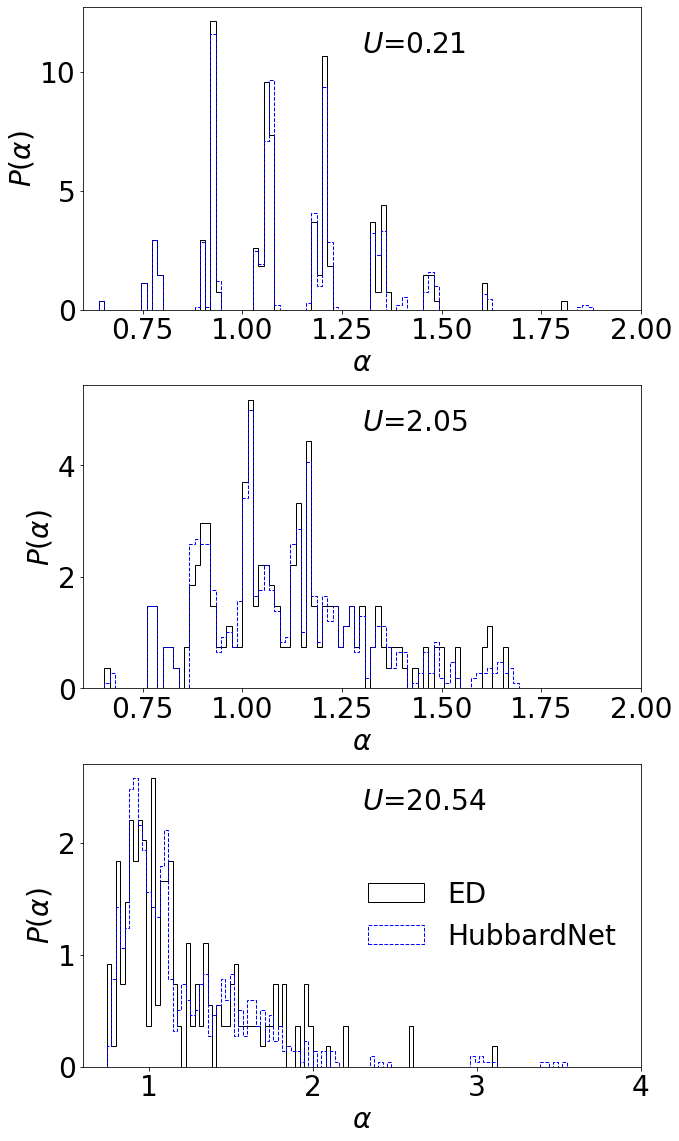

In [17]:
U_test = np.logspace(-2.125, 2.125, 69, endpoint = True)
fig,ax = plt.subplots(3,1,figsize=(10, 19.5), sharex=False)
fig.subplots_adjust(hspace=0.25)


overlap=[]
ovidx=[]
xlimit=[2,2,4]
for (i,U) in enumerate([0.2053525026457146,2.0535250264571463,20.53525026457146]):
    #distrexact=[]
    wf_exact=np.genfromtxt(f'./2D-exact_states/M-{M}-N-{N}-w{w}-h{h}/{U}.csv')
    distr=-np.log(np.power(np.abs(wf_exact),2))/np.log(model.tot_states)
    #distr=distr.tolist()
    #distrexact.append(distr)
    #distrexact=np.array(distrexact)
    n,bins,patches=ax[i].hist(distr,bins=np.linspace(0.,xlimit[i],151),density=1,stacked=True,fill=False,histtype='step',linestyle='solid',color='k', label="ED")
#     ov=[]
#     for kk in ene_idx[0:n_avg_states]:
#         gs_vecs = np.genfromtxt(f'./excited_states_exact/M-{M}-N-{N}/U-{U}-state-{kk}.csv')
#         ov.append(np.dot(gs_vecs,wf_nn))
#     overlap.append(np.max(ov))
#     ovidx.append(ov.index((np.max(ov))))


U_test=U_test.tolist()
for (i,U) in enumerate([0.2053525026457146,2.0535250264571463,20.53525026457146]):
    
    wf_nn=np.genfromtxt(f'./2D-states/2D-ADAM-M-{M}-N-{N}-U_test-{U_train}-lr-{lr}-w{w}-h{h}/U_test-{U}.csv')
    #wf_exact=np.genfromtxt(f'./excited_states_exact/M-{M}-N-{N}/U-{U}-state-{ovidx[U_test.index(U)]}.csv')
    #distr=-np.log(np.power(np.abs(wf_exact),2))/np.log(model.tot_states)
    #n,bins,patches=ax[i].hist(distr,bins=np.linspace(0.,15,151),density=1,stacked=True,fill=False,histtype='step',linestyle='solid',color='k', label="ED")
    distr1=-np.log(np.power(np.abs(wf_nn),2))/np.log(model.tot_states)
    n,bins,patches=ax[i].hist(distr1,bins=np.linspace(0.,xlimit[i],151),density=1,stacked=True,fill=False,histtype='step',linestyle='dashed',color='b', label="HubbardNet")
    ax[i].set_ylabel(r'$P(\alpha)$',fontsize=28)
    ax[i].set_xlabel(r'$\alpha$',fontsize=28)
    ax[i].tick_params(axis='both', which='major', labelsize=28)
    ax[i].text(0.5,0.85 , f'$U$={round(U,2)}',fontsize=28,transform=ax[i].transAxes)
    print(max(distr),min(distr))
ax[0].set_xlim(0.6,xlimit[0])
ax[1].set_xlim(0.6,xlimit[1])
ax[2].set_xlim(0.6,xlimit[2])
plt.legend(frameon=False,prop={'size': 28},loc='center right')
fig.savefig(f"./paper-2D-ground-state/2D-ground-state-alpha-all-M-{M}-N-{N}-w-{w}-h-{h}.pdf",bbox_inches='tight',dpi=1000)

0.006445196380393841 8.978259426009058e-10
0.006445196380393841 8.978259426009058e-10
0.006445196380393841 8.978259426009058e-10


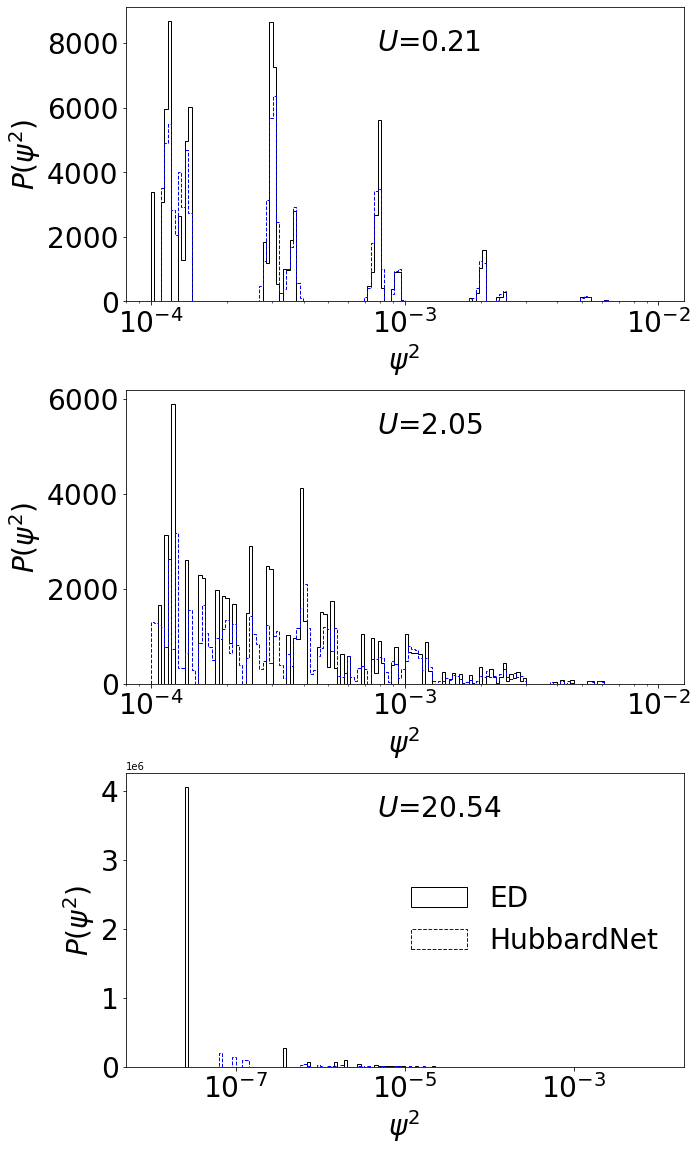

In [7]:
U_test = np.logspace(-2.125, 2.125, 69, endpoint = True)
fig,ax = plt.subplots(3,1,figsize=(10, 19.5), sharex=False)
fig.subplots_adjust(hspace=0.3)


overlap=[]
ovidx=[]
uplimit=[-2,-2,-2]
lowlimit=[-4,-4,-8]
for (i,U) in enumerate([0.2053525026457146,2.0535250264571463,20.53525026457146]):
#for (i,U) in enumerate([0.2053525026457146,2.0535250264571463,31.622776601683793]):
    #distrexact=[]
    wf_exact=np.genfromtxt(f'./2D-exact_states/M-{M}-N-{N}-w{w}-h{h}/{U}.csv')
    #distr=-np.log(np.power(np.abs(wf_exact),2))/np.log(model.tot_states)
    distr=np.power(np.abs(wf_exact),2)
    #distr=distr.tolist()
    #distrexact.append(distr)
    #distrexact=np.array(distrexact)
    n,bins,patches=ax[i].hist(distr,bins=np.logspace(lowlimit[i],uplimit[i],151),density=1,stacked=True,fill=False,histtype='step',linestyle='solid',color='k', label="ED")
#     ov=[]
#     for kk in ene_idx[0:n_avg_states]:
#         gs_vecs = np.genfromtxt(f'./excited_states_exact/M-{M}-N-{N}/U-{U}-state-{kk}.csv')
#         ov.append(np.dot(gs_vecs,wf_nn))
#     overlap.append(np.max(ov))
#     ovidx.append(ov.index((np.max(ov))))


U_test=U_test.tolist()
for (i,U) in enumerate([0.2053525026457146,2.0535250264571463,20.53525026457146]):
#for (i,U) in enumerate([0.2053525026457146,2.0535250264571463,31.622776601683793]):    
    wf_nn=np.genfromtxt(f'./2D-states/2D-ADAM-M-{M}-N-{N}-U_test-{U_train}-lr-{lr}-w{w}-h{h}/U_test-{U}.csv')
    #wf_exact=np.genfromtxt(f'./excited_states_exact/M-{M}-N-{N}/U-{U}-state-{ovidx[U_test.index(U)]}.csv')
    #distr=-np.log(np.power(np.abs(wf_exact),2))/np.log(model.tot_states)
    #n,bins,patches=ax[i].hist(distr,bins=np.linspace(0.,15,151),density=1,stacked=True,fill=False,histtype='step',linestyle='solid',color='k', label="ED")
    #distr1=-np.log(np.power(np.abs(wf_nn),2))/np.log(model.tot_states)
    distr1=np.power(np.abs(wf_nn),2)
    n,bins,patches=ax[i].hist(distr1,bins=np.logspace(lowlimit[i],uplimit[i],151),density=1,stacked=True,fill=False,histtype='step',linestyle='dashed',color='b', label="HubbardNet")
    ax[i].set_ylabel(r'$P(\psi^2)$',fontsize=28)
    ax[i].set_xlabel(r'$\psi^2$',fontsize=28)
    ax[i].tick_params(axis='both', which='major', labelsize=28)
    ax[i].text(0.45,0.85 , f'$U$={round(U,2)}',fontsize=28,transform=ax[i].transAxes)
    print(max(distr),min(distr))
#ax[0].set_xlim(0.5,xlimit[0])
#ax[1].set_xlim(0.2,xlimit[1])
#ax[2].set_xlim(0,xlimit[2])
ax[0].set_xscale('log')
ax[1].set_xscale('log')
ax[2].set_xscale('log')
plt.legend(frameon=False,prop={'size': 28},loc='center right')
fig.savefig(f"./paper-2D-ground-state/2D-ground-state-psi2-M-{M}-N-{N}-w-{w}-h-{h}.pdf",bbox_inches='tight',dpi=1000)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_907847/3281576883.py:83: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(0,160)


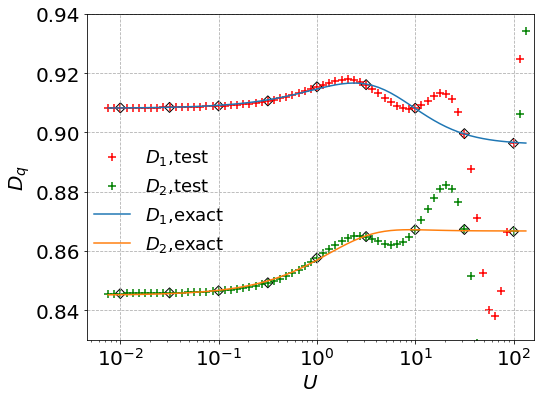

In [61]:
# M=4
# N=4
# w=2
# h=2
# lr=5e-6
# U_train =[0.05,0.1,0.5,1,5,20,50]
# U_test = np.logspace(-2, 2, 61, endpoint = True) 

plt.figure(figsize=(8,6))


q=1
D1=[]
for U in U_train:
    gs_vecs = np.genfromtxt(f'./2D-states/2D-ADAM-M-{M}-N-{N}-U_train-{U_train}-lr-{lr}-w{w}-h{h}/U_train-{U}.csv')
    gs_frac = -np.sum(np.power(gs_vecs,2*q)*np.log(np.power(gs_vecs,2*q)))
    D1.append(gs_frac/np.log(model.tot_states))
#plt.scatter(U_train,D1,label=r'$D_1$,train',color='black',s=50,facecolors='none')
plt.scatter(U_train,D1,color='black',marker='D',s=50,facecolors='none')

q=2
D2=[]
for U in U_train:
    gs_vecs = np.genfromtxt(f'./2D-states/2D-ADAM-M-{M}-N-{N}-U_train-{U_train}-lr-{lr}-w{w}-h{h}/U_train-{U}.csv')
    gs_frac = 1/(1-q)*np.log(np.sum(np.power(gs_vecs,2*q)))
    D2.append(gs_frac/np.log(model.tot_states))
#plt.scatter(U_train,D2,label=r'$D_2$,train',color='black',marker='s',s=50,facecolors='none')
plt.scatter(U_train,D2,color='black',marker='D',s=50,facecolors='none')
plt.xscale('log')
plt.xlabel('U')
plt.ylabel(r'$D_q$')
plt.legend()





q=1
D1=[]
for U in U_test:
    gs_vecs = np.genfromtxt(f'./2D-states/2D-ADAM-M-{M}-N-{N}-U_test-{U_train}-lr-{lr}-w{w}-h{h}/U_test-{U}.csv')
    #gs_vecs_test = np.genfromtxt(f'./exact_states/M-{M}-N-{N}/{U}.csv')
    gs_frac = -np.sum(np.power(gs_vecs,2*q)*np.log(np.power(gs_vecs,2*q)))
    D1.append(gs_frac/np.log(model.tot_states))
plt.scatter(U_test,D1,label=r'$D_1$,test',marker='+',color='r',s=50)
#plt.xlabel('U')
#plt.ylabel(r'$D_1$')
q=2
D2=[]
for U in U_test:
    gs_vecs = np.genfromtxt(f'./2D-states/2D-ADAM-M-{M}-N-{N}-U_test-{U_train}-lr-{lr}-w{w}-h{h}/U_test-{U}.csv')
    gs_frac = 1/(1-q)*np.log(np.sum(np.power(gs_vecs,2*q)))
    D2.append(gs_frac/np.log(model.tot_states))
plt.scatter(U_test,D2,label=r'$D_2$,test',marker='+',color='g',s=50)
plt.xscale('log')
plt.xlabel(r'$U$',fontsize=20)
plt.ylabel(r'$D_q$',fontsize=20)
plt.legend()

q=1
D1=[]
for U in U_test:
    gs_vecs = np.genfromtxt(f'./2D-exact_states/M-{M}-N-{N}-w{w}-h{h}/{U}.csv')
    #gs_vecs_test = np.genfromtxt(f'./exact_states/M-{M}-N-{N}/{U}.csv')
    gs_frac = -np.sum(np.power(gs_vecs,2*q)*np.log(np.power(gs_vecs,2*q)))
    D1.append(gs_frac/np.log(model.tot_states))
plt.plot(U_test,D1,label=r'$D_1$,exact')
#plt.xlabel('U')
#plt.ylabel(r'$D_1$')
q=2
D2=[]
for U in U_test:
    gs_vecs = np.genfromtxt(f'./2D-exact_states/M-{M}-N-{N}-w{w}-h{h}/{U}.csv')
    gs_frac = 1/(1-q)*np.log(np.sum(np.power(gs_vecs,2*q)))
    D2.append(gs_frac/np.log(model.tot_states))
plt.plot(U_test,D2,label=r'$D_2$,exact')
plt.xscale('log')
plt.xlabel(r'$U$')
plt.ylabel(r'$D_q$')
plt.legend(fontsize=18,frameon=False,loc='center left', bbox_to_anchor=(-0.02, 0.177, 0.5, 0.5))
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlim(0,160)
plt.ylim(0.83,0.94)
#plt.savefig(f'./figures/Dq/Dq-step-1000-ADAM-M-{M}-N-{N}-lr-{lr}-U_train-{U_train}.pdf')
#plt.savefig(f'./regensburg/Dq-ADAM-M-{M}-N-{N}-lr-{lr}-U_train-{U_train}.pdf', format='pdf',bbox_inches='tight',dpi=1000)
plt.grid(linestyle='dashed')
plt.savefig(f'./paper-2D-ground-state/2D-ground-state-Dq-M-{M}-N-{N}-w-{w}-h-{h}.pdf',bbox_inches='tight',dpi=1000)
plt.show()
#plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/tmp/ipykernel_907847/3112372182.py:171: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(0,160)


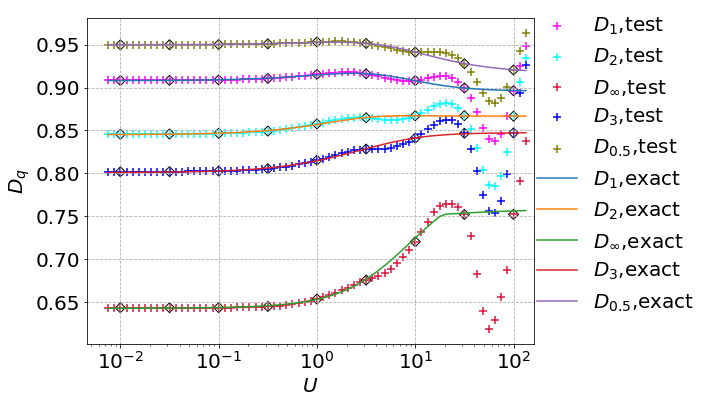

In [64]:
plt.figure(figsize=(8,6))


q=1
D1=[]
for U in U_train:
    gs_vecs = np.genfromtxt(f'./2D-states/2D-ADAM-M-{M}-N-{N}-U_train-{U_train}-lr-{lr}-w{w}-h{h}/U_train-{U}.csv')
    gs_frac = -np.sum(np.power(gs_vecs,2*q)*np.log(np.power(gs_vecs,2*q)))
    D1.append(gs_frac/np.log(model.tot_states))
#plt.scatter(U_train,D1,label=r'$D_1$,train',color='black',s=50,facecolors='none')
plt.scatter(U_train,D1,color='black',marker='D',s=50,facecolors='none')

q=2
D2=[]
for U in U_train:
    gs_vecs = np.genfromtxt(f'./2D-states/2D-ADAM-M-{M}-N-{N}-U_train-{U_train}-lr-{lr}-w{w}-h{h}/U_train-{U}.csv')
    gs_frac = 1/(1-q)*np.log(np.sum(np.power(gs_vecs,2*q)))
    D2.append(gs_frac/np.log(model.tot_states))
#plt.scatter(U_train,D2,label=r'$D_2$,train',color='black',marker='s',s=50,facecolors='none')
plt.scatter(U_train,D2,color='black',marker='D',s=50,facecolors='none')
plt.xscale('log')
plt.xlabel('U')
plt.ylabel(r'$D_q$')
plt.legend()

Dinf=[]
for U in U_train:
    gs_vecs = np.genfromtxt(f'./2D-states/2D-ADAM-M-{M}-N-{N}-U_train-{U_train}-lr-{lr}-w{w}-h{h}/U_train-{U}.csv')
    gs_frac = -np.log(np.max(np.power(np.abs(gs_vecs),2)))
    Dinf.append(gs_frac/np.log(model.tot_states))
#plt.scatter(U_train,D2,label=r'$D_2$,train',color='black',marker='s',s=50,facecolors='none')
plt.scatter(U_train,Dinf,color='black',marker='D',s=50,facecolors='none')
plt.xscale('log')
plt.xlabel('U')
plt.ylabel(r'$D_q$')
plt.legend()

q=3
D3=[]
for U in U_train:
    gs_vecs = np.genfromtxt(f'./2D-states/2D-ADAM-M-{M}-N-{N}-U_train-{U_train}-lr-{lr}-w{w}-h{h}/U_train-{U}.csv')
    gs_frac = 1/(1-q)*np.log(np.sum(np.power(gs_vecs,2*q)))
    D3.append(gs_frac/np.log(model.tot_states))
#plt.scatter(U_train,D2,label=r'$D_2$,train',color='black',marker='s',s=50,facecolors='none')
plt.scatter(U_train,D3,color='black',marker='D',s=50,facecolors='none')
plt.xscale('log')
plt.xlabel('U')
plt.ylabel(r'$D_q$')
plt.legend()

q=0.5
Dhalf=[]
for U in U_train:
    gs_vecs = np.genfromtxt(f'./2D-states/2D-ADAM-M-{M}-N-{N}-U_train-{U_train}-lr-{lr}-w{w}-h{h}/U_train-{U}.csv')
    gs_frac = 1/(1-q)*np.log(np.sum(np.power(np.abs(gs_vecs),2*q)))
    Dhalf.append(gs_frac/np.log(model.tot_states))
#plt.scatter(U_train,D2,label=r'$D_2$,train',color='black',marker='s',s=50,facecolors='none')
plt.scatter(U_train,Dhalf,color='black',marker='D',s=50,facecolors='none')
plt.xscale('log')
plt.xlabel('U')
plt.ylabel(r'$D_q$')
plt.legend()


q=1
D1=[]
for U in U_test:
    gs_vecs = np.genfromtxt(f'./2D-states/2D-ADAM-M-{M}-N-{N}-U_test-{U_train}-lr-{lr}-w{w}-h{h}/U_test-{U}.csv')
    #gs_vecs_test = np.genfromtxt(f'./exact_states/M-{M}-N-{N}/{U}.csv')
    gs_frac = -np.sum(np.power(gs_vecs,2*q)*np.log(np.power(gs_vecs,2*q)))
    D1.append(gs_frac/np.log(model.tot_states))
plt.scatter(U_test,D1,label=r'$D_1$,test',marker='+',color='magenta',s=50)
#plt.xlabel('U')
#plt.ylabel(r'$D_1$')
q=2
D2=[]
for U in U_test:
    gs_vecs = np.genfromtxt(f'./2D-states/2D-ADAM-M-{M}-N-{N}-U_test-{U_train}-lr-{lr}-w{w}-h{h}/U_test-{U}.csv')
    gs_frac = 1/(1-q)*np.log(np.sum(np.power(gs_vecs,2*q)))
    D2.append(gs_frac/np.log(model.tot_states))
plt.scatter(U_test,D2,label=r'$D_2$,test',marker='+',color='cyan',s=50)
plt.xscale('log')
plt.xlabel(r'$U$',fontsize=20)
plt.ylabel(r'$D_q$',fontsize=20)
plt.legend()

Dinf=[]
for U in U_test:
    gs_vecs = np.genfromtxt(f'./2D-states/2D-ADAM-M-{M}-N-{N}-U_test-{U_train}-lr-{lr}-w{w}-h{h}/U_test-{U}.csv')
    gs_frac = -np.log(np.max(np.power(np.abs(gs_vecs),2)))
    Dinf.append(gs_frac/np.log(model.tot_states))
plt.scatter(U_test,Dinf,label=r'$D_{\infty}$,test',marker='+',color='crimson',s=50)
plt.xscale('log')
plt.xlabel(r'$U$',fontsize=20)
plt.ylabel(r'$D_q$',fontsize=20)
plt.legend()

q=3
D3=[]
for U in U_test:
    gs_vecs = np.genfromtxt(f'./2D-states/2D-ADAM-M-{M}-N-{N}-U_test-{U_train}-lr-{lr}-w{w}-h{h}/U_test-{U}.csv')
    gs_frac = 1/(1-q)*np.log(np.sum(np.power(gs_vecs,2*q)))
    D3.append(gs_frac/np.log(model.tot_states))
plt.scatter(U_test,D3,label=r'$D_3$,test',marker='+',color='blue',s=50)
plt.xscale('log')
plt.xlabel(r'$U$',fontsize=20)
plt.ylabel(r'$D_q$',fontsize=20)
plt.legend()

q=0.5
Dhalf=[]
for U in U_test:
    gs_vecs = np.genfromtxt(f'./2D-states/2D-ADAM-M-{M}-N-{N}-U_test-{U_train}-lr-{lr}-w{w}-h{h}/U_test-{U}.csv')
    gs_frac = 1/(1-q)*np.log(np.sum(np.power(gs_vecs,2*q)))
    Dhalf.append(gs_frac/np.log(model.tot_states))
plt.scatter(U_test,Dhalf,label='$D_{0.5}$,test',marker='+',color='olive',s=50)
plt.xscale('log')
plt.xlabel(r'$U$',fontsize=20)
plt.ylabel(r'$D_q$',fontsize=20)
plt.legend()

q=1
D1=[]
for U in U_test:
    gs_vecs = np.genfromtxt(f'./2D-exact_states/M-{M}-N-{N}-w{w}-h{h}/{U}.csv')
    #gs_vecs_test = np.genfromtxt(f'./exact_states/M-{M}-N-{N}/{U}.csv')
    gs_frac = -np.sum(np.power(gs_vecs,2*q)*np.log(np.power(gs_vecs,2*q)))
    D1.append(gs_frac/np.log(model.tot_states))
plt.plot(U_test,D1,label=r'$D_1$,exact')
#plt.xlabel('U')
#plt.ylabel(r'$D_1$')
q=2
D2=[]
for U in U_test:
    gs_vecs = np.genfromtxt(f'./2D-exact_states/M-{M}-N-{N}-w{w}-h{h}/{U}.csv')
    gs_frac = 1/(1-q)*np.log(np.sum(np.power(gs_vecs,2*q)))
    D2.append(gs_frac/np.log(model.tot_states))
plt.plot(U_test,D2,label=r'$D_2$,exact')


Dinf=[]
for U in U_test:
    gs_vecs = np.genfromtxt(f'./2D-exact_states/M-{M}-N-{N}-w{w}-h{h}/{U}.csv')
    gs_frac = -np.log(np.max(np.power(np.abs(gs_vecs),2)))
    Dinf.append(gs_frac/np.log(model.tot_states))
plt.plot(U_test,Dinf,label=r'$D_{\infty}$,exact')

q=3
D3=[]
for U in U_test:
    gs_vecs = np.genfromtxt(f'./2D-exact_states/M-{M}-N-{N}-w{w}-h{h}/{U}.csv')
    gs_frac = 1/(1-q)*np.log(np.sum(np.power(gs_vecs,2*q)))
    D3.append(gs_frac/np.log(model.tot_states))
plt.plot(U_test,D3,label=r'$D_3$,exact')

q=0.5
Dhalf=[]
for U in U_test:
    gs_vecs = np.genfromtxt(f'./2D-exact_states/M-{M}-N-{N}-w{w}-h{h}/{U}.csv')
    gs_frac = 1/(1-q)*np.log(np.sum(np.power(np.abs(gs_vecs),2*q)))
    Dhalf.append(gs_frac/np.log(model.tot_states))
plt.plot(U_test,Dhalf,label='$D_{0.5}$,exact')


plt.xscale('log')
plt.xlabel(r'$U$')
plt.ylabel(r'$D_q$')
plt.legend(fontsize=20,frameon=False,loc='center right',bbox_to_anchor=(0.4, 0.5, 1., .102))
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlim(0,160)
#plt.ylim(0.83,0.94)
#plt.savefig(f'./figures/Dq/Dq-step-1000-ADAM-M-{M}-N-{N}-lr-{lr}-U_train-{U_train}.pdf')
#plt.savefig(f'./regensburg/Dq-ADAM-M-{M}-N-{N}-lr-{lr}-U_train-{U_train}.pdf', format='pdf',bbox_inches='tight',dpi=1000)
plt.grid(linestyle='dashed')
plt.savefig(f'./paper-2D-ground-state/2D-ground-state-Dq-M-{M}-N-{N}-w-{w}-h-{h}-all.pdf',bbox_inches='tight',dpi=1000)
plt.show()
#plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


[3.38701550e-05 4.18860644e-05 2.22613026e-04 3.54418235e-04
 7.32286106e-04 2.07246865e-04 9.31913830e-05 1.12756620e-04
 3.23157001e-04]
[3.91808716e-04 2.33637797e-04 1.66180838e-04 6.61747225e-04
 7.34112972e-04 2.76170517e-04 3.99068600e-05 4.26054700e-04
 1.75967476e-04]


/tmp/ipykernel_7875/2869148078.py:132: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(0,160)


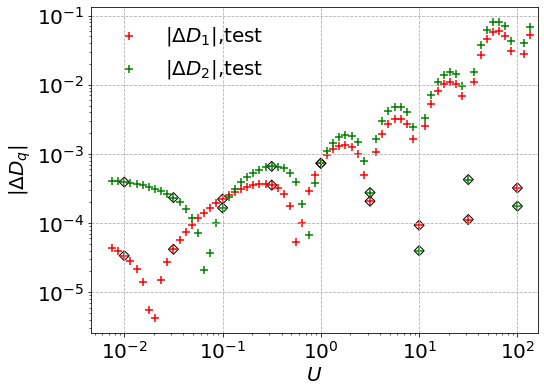

In [9]:
U_test = np.logspace(-2.125, 2.125, 69, endpoint = True) 
plt.figure(figsize=(8,6))

q=1
D1=[]
for U in U_train:
    gs_vecs = np.genfromtxt(f'./2D-exact_states/M-{M}-N-{N}-w{w}-h{h}/{U}.csv')
    #gs_vecs_test = np.genfromtxt(f'./exact_states/M-{M}-N-{N}/{U}.csv')
    gs_frac = -np.sum(np.power(gs_vecs,2*q)*np.log(np.power(gs_vecs,2*q)))
    D1.append(gs_frac/np.log(model.tot_states))
#plt.plot(U_test,D1,label=r'$D_1$,exact')
#plt.xlabel('U')
#plt.ylabel(r'$D_1$')
q=2
D2=[]
for U in U_train:
    gs_vecs = np.genfromtxt(f'./2D-exact_states/M-{M}-N-{N}-w{w}-h{h}/{U}.csv')
    gs_frac = 1/(1-q)*np.log(np.sum(np.power(gs_vecs,2*q)))
    D2.append(gs_frac/np.log(model.tot_states))
#plt.plot(U_test,D2,label=r'$D_2$,exact')

# Dinf=[]
# for U in U_test:
#     gs_vecs = np.genfromtxt(f'./exact_states/M-{M}-N-{N}/{U}.csv')
#     gs_frac = -np.log(np.max(np.power(np.abs(gs_vecs),2)))
#     Dinf.append(gs_frac/np.log(model.tot_states))
# plt.plot(U_test,Dinf,label=r'$D_\infty$,exact')





q=1
D1train=[]
for U in U_train:
    gs_vecs = np.genfromtxt(f'./2D-states/2D-ADAM-M-{M}-N-{N}-U_train-{U_train}-lr-{lr}-w{w}-h{h}/U_train-{U}.csv')
    gs_frac = -np.sum(np.power(gs_vecs,2*q)*np.log(np.power(gs_vecs,2*q)))
    D1train.append(gs_frac/np.log(model.tot_states))
#plt.scatter(U_train,np.abs(np.array(D1train)-np.array(D1)),label=r'$\Delta D_1$,train',color='black',s=50)
plt.scatter(U_train,np.abs(np.array(D1train)-np.array(D1)),facecolors='none',color='black',s=50,marker='D')
print(np.abs(np.array(D1train)-np.array(D1)))


q=2
D2train=[]
for U in U_train:
    gs_vecs = np.genfromtxt(f'./2D-states/2D-ADAM-M-{M}-N-{N}-U_train-{U_train}-lr-{lr}-w{w}-h{h}/U_train-{U}.csv')
    gs_frac = 1/(1-q)*np.log(np.sum(np.power(gs_vecs,2*q)))
    D2train.append(gs_frac/np.log(model.tot_states))
#plt.scatter(U_train,np.abs(np.array(D2train)-np.array(D2)),label=r'$\Delta D_2$,train',color='black',marker='s',s=50)
plt.scatter(U_train,np.abs(np.array(D2train)-np.array(D2)),facecolors='none',color='black',marker='D',s=50)
plt.xscale('log')
plt.xlabel(r'$U$')
plt.ylabel(r'$D_q$')
plt.legend()
print(np.abs(np.array(D2train)-np.array(D2)))


# Dinf=[]
# for U in U_train:
#     gs_vecs = np.genfromtxt(f'./ground-state-psi/ADAM-cc-{cc}-M-{M}-N-{N}-U_train-{U_train}-lr-{lr}/U_train-{U}.csv')
#     gs_frac = -np.log(np.max(np.power(np.abs(gs_vecs),2)))
#     Dinf.append(gs_frac/np.log(model.tot_states))
# plt.scatter(U_train,Dinf,label=r'$D_\infty$,train',color='black',marker='s',s=50)
# plt.xscale('log')
# plt.xlabel(r'$U$')
# plt.ylabel(r'$D_q$')
# plt.legend()



q=1
D1=[]
for U in U_test:
    gs_vecs = np.genfromtxt(f'./2D-exact_states/M-{M}-N-{N}-w{w}-h{h}/{U}.csv')
    #gs_vecs_test = np.genfromtxt(f'./exact_states/M-{M}-N-{N}/{U}.csv')
    gs_frac = -np.sum(np.power(gs_vecs,2*q)*np.log(np.power(gs_vecs,2*q)))
    D1.append(gs_frac/np.log(model.tot_states))

q=2
D2=[]
for U in U_test:
    gs_vecs = np.genfromtxt(f'./2D-exact_states/M-{M}-N-{N}-w{w}-h{h}/{U}.csv')
    gs_frac = 1/(1-q)*np.log(np.sum(np.power(gs_vecs,2*q)))
    D2.append(gs_frac/np.log(model.tot_states))



q=1
D1test=[]
for U in U_test:
    gs_vecs = np.genfromtxt(f'./2D-states/2D-ADAM-M-{M}-N-{N}-U_test-{U_train}-lr-{lr}-w{w}-h{h}/U_test-{U}.csv')
    gs_frac = -np.sum(np.power(gs_vecs,2*q)*np.log(np.power(gs_vecs,2*q)))
    D1test.append(gs_frac/np.log(model.tot_states))
plt.scatter(U_test,np.abs(np.array(D1test)-np.array(D1)),label=r'$|\Delta D_1|$,test',marker='+',color='r',s=50)

q=2
D2test=[]
for U in U_test:
    gs_vecs = np.genfromtxt(f'./2D-states/2D-ADAM-M-{M}-N-{N}-U_test-{U_train}-lr-{lr}-w{w}-h{h}/U_test-{U}.csv')
    gs_frac = 1/(1-q)*np.log(np.sum(np.power(gs_vecs,2*q)))
    D2test.append(gs_frac/np.log(model.tot_states))
plt.scatter(U_test,np.abs(np.array(D2test)-np.array(D2)),label=r'$|\Delta D_2|$,test',marker='+',color='g',s=50)
plt.xscale('log')
plt.xlabel(r'$U$')
plt.ylabel(r'$\delta D_q$')
plt.legend()

# Dinf=[]
# for U in U_test:
#     gs_vecs = np.genfromtxt(f'./ground-state-psi/ADAM-cc-{cc}-M-{M}-N-{N}-U_test-{U_train}-lr-{lr}/U_test-{U}.csv')
#     gs_frac = -np.log(np.max(np.power(np.abs(gs_vecs),2)))
#     Dinf.append(gs_frac/np.log(model.tot_states))
# plt.scatter(U_test,Dinf,label=r'$D_\infty$,test',marker='x',color='g',s=50)
# plt.xscale('log')
# plt.xlabel(r'$U$')
# plt.ylabel(r'$D_q$')
# plt.legend()






plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$U$',fontsize=20)
plt.ylabel(r'$|\Delta D_q|$',fontsize=20)
plt.legend(fontsize=20,frameon=False,loc='upper left')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlim(0,160)
#plt.savefig(f'./new-loss/new-figures/Dq/Dq-ADAM-cc-{cc}-M-{M}-N-{N}-lr-{lr}-U_train-{U_train}.pdf')
#plt.savefig(f'./figures/report/Dq/Dq-ADAM-cc-{cc}-M-{M}-N-{N}-lr-{lr}-U_train-{U_train}.pdf')
plt.grid(linestyle='dashed')
plt.savefig(f"./paper-2D-ground-state/2D-ground-state-deltaDq-M-{M}-N-{N}-w-{w}-h-{h}-len_U_train-{len(U_train)}.pdf",bbox_inches='tight',dpi=1000)
plt.show()

[3.72922799e-05 4.61068046e-05 2.44864180e-04 3.89058096e-04
 8.00636081e-04 2.26179189e-04 1.02629581e-04 1.25362360e-04
 3.60411965e-04]
[4.63545634e-04 2.76293554e-04 1.96258664e-04 7.78605990e-04
 8.56682261e-04 3.19229853e-04 4.60208048e-05 4.91511296e-04
 2.03020817e-04]


/tmp/ipykernel_7875/3162569993.py:128: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(0,160)


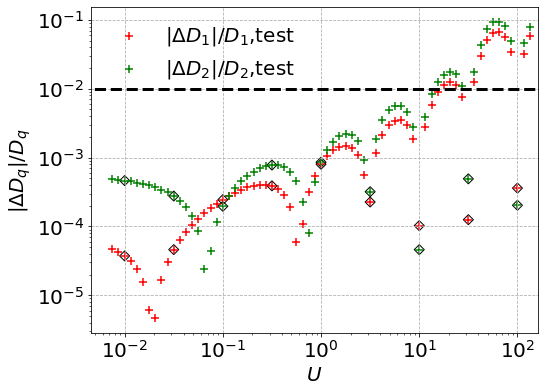

In [17]:
U_test = np.logspace(-2.125, 2.125, 69, endpoint = True) 
plt.figure(figsize=(8,6))

q=1
D1=[]
for U in U_train:
    gs_vecs = np.genfromtxt(f'./2D-exact_states/M-{M}-N-{N}-w{w}-h{h}/{U}.csv')
    #gs_vecs_test = np.genfromtxt(f'./exact_states/M-{M}-N-{N}/{U}.csv')
    gs_frac = -np.sum(np.power(gs_vecs,2*q)*np.log(np.power(gs_vecs,2*q)))
    D1.append(gs_frac/np.log(model.tot_states))
#plt.plot(U_test,D1,label=r'$D_1$,exact')
#plt.xlabel('U')
#plt.ylabel(r'$D_1$')
q=2
D2=[]
for U in U_train:
    gs_vecs = np.genfromtxt(f'./2D-exact_states/M-{M}-N-{N}-w{w}-h{h}/{U}.csv')
    gs_frac = 1/(1-q)*np.log(np.sum(np.power(gs_vecs,2*q)))
    D2.append(gs_frac/np.log(model.tot_states))
#plt.plot(U_test,D2,label=r'$D_2$,exact')

# Dinf=[]
# for U in U_test:
#     gs_vecs = np.genfromtxt(f'./exact_states/M-{M}-N-{N}/{U}.csv')
#     gs_frac = -np.log(np.max(np.power(np.abs(gs_vecs),2)))
#     Dinf.append(gs_frac/np.log(model.tot_states))
# plt.plot(U_test,Dinf,label=r'$D_\infty$,exact')





q=1
D1train=[]
for U in U_train:
    gs_vecs = np.genfromtxt(f'./2D-states/2D-ADAM-M-{M}-N-{N}-U_train-{U_train}-lr-{lr}-w{w}-h{h}/U_train-{U}.csv')
    gs_frac = -np.sum(np.power(gs_vecs,2*q)*np.log(np.power(gs_vecs,2*q)))
    D1train.append(gs_frac/np.log(model.tot_states))
#plt.scatter(U_train,np.abs(np.array(D1train)-np.array(D1))/np.array(D1),label=r'$|\Delta D_1|/D_1$,train',color='black',s=50)
plt.scatter(U_train,np.abs(np.array(D1train)-np.array(D1))/np.array(D1),facecolors='none',color='black',s=50,marker='D')
print(np.abs(np.array(D1train)-np.array(D1))/np.array(D1))


q=2
D2train=[]
for U in U_train:
    gs_vecs = np.genfromtxt(f'./2D-states/2D-ADAM-M-{M}-N-{N}-U_train-{U_train}-lr-{lr}-w{w}-h{h}/U_train-{U}.csv')
    gs_frac = 1/(1-q)*np.log(np.sum(np.power(gs_vecs,2*q)))
    D2train.append(gs_frac/np.log(model.tot_states))
#plt.scatter(U_train,np.abs(np.array(D2train)-np.array(D2))/np.array(D2),label=r'$|\Delta D_2|/D_2$,train',color='black',marker='s',s=50)
plt.scatter(U_train,np.abs(np.array(D2train)-np.array(D2))/np.array(D2),facecolors='none',color='black',marker='D',s=50)
print(np.abs(np.array(D2train)-np.array(D2))/np.array(D2))


# Dinf=[]
# for U in U_train:
#     gs_vecs = np.genfromtxt(f'./ground-state-psi/ADAM-cc-{cc}-M-{M}-N-{N}-U_train-{U_train}-lr-{lr}/U_train-{U}.csv')
#     gs_frac = -np.log(np.max(np.power(np.abs(gs_vecs),2)))
#     Dinf.append(gs_frac/np.log(model.tot_states))
# plt.scatter(U_train,Dinf,label=r'$D_\infty$,train',color='black',marker='s',s=50)
# plt.xscale('log')
# plt.xlabel(r'$U$')
# plt.ylabel(r'$D_q$')
# plt.legend()



q=1
D1=[]
for U in U_test:
    gs_vecs = np.genfromtxt(f'./2D-exact_states/M-{M}-N-{N}-w{w}-h{h}/{U}.csv')
    #gs_vecs_test = np.genfromtxt(f'./exact_states/M-{M}-N-{N}/{U}.csv')
    gs_frac = -np.sum(np.power(gs_vecs,2*q)*np.log(np.power(gs_vecs,2*q)))
    D1.append(gs_frac/np.log(model.tot_states))

q=2
D2=[]
for U in U_test:
    gs_vecs = np.genfromtxt(f'./2D-exact_states/M-{M}-N-{N}-w{w}-h{h}/{U}.csv')
    gs_frac = 1/(1-q)*np.log(np.sum(np.power(gs_vecs,2*q)))
    D2.append(gs_frac/np.log(model.tot_states))



q=1
D1test=[]
for U in U_test:
    gs_vecs = np.genfromtxt(f'./2D-states/2D-ADAM-M-{M}-N-{N}-U_test-{U_train}-lr-{lr}-w{w}-h{h}/U_test-{U}.csv')
    gs_frac = -np.sum(np.power(gs_vecs,2*q)*np.log(np.power(gs_vecs,2*q)))
    D1test.append(gs_frac/np.log(model.tot_states))
plt.scatter(U_test,np.abs(np.array(D1test)-np.array(D1))/np.array(D1),label=r'$|\Delta D_1|/D_1$,test',marker='+',color='r',s=50)

q=2
D2test=[]
for U in U_test:
    gs_vecs = np.genfromtxt(f'./2D-states/2D-ADAM-M-{M}-N-{N}-U_test-{U_train}-lr-{lr}-w{w}-h{h}/U_test-{U}.csv')
    gs_frac = 1/(1-q)*np.log(np.sum(np.power(gs_vecs,2*q)))
    D2test.append(gs_frac/np.log(model.tot_states))
plt.scatter(U_test,np.abs(np.array(D2test)-np.array(D2))/np.array(D2),label=r'$|\Delta D_2|/D_2$,test',marker='+',color='g',s=50)
plt.xscale('log')
plt.xlabel(r'$U$')
plt.ylabel(r'$\delta D_q$')
plt.legend()

# Dinf=[]
# for U in U_test:
#     gs_vecs = np.genfromtxt(f'./ground-state-psi/ADAM-cc-{cc}-M-{M}-N-{N}-U_test-{U_train}-lr-{lr}/U_test-{U}.csv')
#     gs_frac = -np.log(np.max(np.power(np.abs(gs_vecs),2)))
#     Dinf.append(gs_frac/np.log(model.tot_states))
# plt.scatter(U_test,Dinf,label=r'$D_\infty$,test',marker='x',color='g',s=50)
# plt.xscale('log')
# plt.xlabel(r'$U$')
# plt.ylabel(r'$D_q$')
# plt.legend()





plt.hlines(y=0.01,xmin=0.,xmax=160,color="black",linestyle='dashed',lw=3)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$U$',fontsize=20)
plt.ylabel(r'$|\Delta D_q|/D_q$',fontsize=20)
plt.legend(fontsize=20,frameon=False,loc='upper left')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlim(0,160)
#plt.savefig(f'./new-loss/new-figures/Dq/Dq-ADAM-cc-{cc}-M-{M}-N-{N}-lr-{lr}-U_train-{U_train}.pdf')
#plt.savefig(f'./figures/report/Dq/Dq-ADAM-cc-{cc}-M-{M}-N-{N}-lr-{lr}-U_train-{U_train}.pdf')
plt.grid(linestyle='dashed')
plt.savefig(f"./paper-2D-ground-state/2D-ground-state-deltaDqDq-M-{M}-N-{N}-w-{w}-h-{h}-len_U_train-{len(U_train)}.pdf",bbox_inches='tight',dpi=1000)
plt.show()

/tmp/ipykernel_7875/1461312161.py:238: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(0,160)


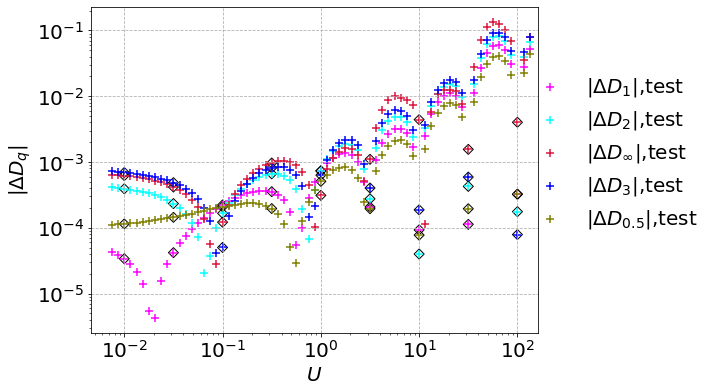

In [14]:
U_test = np.logspace(-2.125, 2.125, 69, endpoint = True) 
plt.figure(figsize=(8,6))


q=1
D1e=[]
for U in U_train:
    gs_vecs = np.genfromtxt(f'./2D-exact_states/M-{M}-N-{N}-w{w}-h{h}/{U}.csv')
    #gs_vecs_test = np.genfromtxt(f'./exact_states/M-{M}-N-{N}/{U}.csv')
    gs_frac = -np.sum(np.power(gs_vecs,2*q)*np.log(np.power(gs_vecs,2*q)))
    D1e.append(gs_frac/np.log(model.tot_states))
#plt.plot(U_test,D1,label=r'$D_1$,exact')


q=1
D1=[]
for U in U_train:
    gs_vecs = np.genfromtxt(f'./2D-states/2D-ADAM-M-{M}-N-{N}-U_train-{U_train}-lr-{lr}-w{w}-h{h}/U_train-{U}.csv')
    gs_frac = -np.sum(np.power(gs_vecs,2*q)*np.log(np.power(gs_vecs,2*q)))
    D1.append(gs_frac/np.log(model.tot_states))
#plt.scatter(U_train,D1,label=r'$D_1$,train',color='black',s=50)
plt.scatter(U_train,np.abs(np.array(D1)-np.array(D1e)),color='black',s=50,marker='D',facecolors='none')


q=2
D2e=[]
for U in U_train:
    gs_vecs = np.genfromtxt(f'./2D-exact_states/M-{M}-N-{N}-w{w}-h{h}/{U}.csv')
    gs_frac = 1/(1-q)*np.log(np.sum(np.power(gs_vecs,2*q)))
    D2e.append(gs_frac/np.log(model.tot_states))
#plt.plot(U_test,D2,label=r'$D_2$,exact')

q=2
D2=[]
for U in U_train:
    gs_vecs = np.genfromtxt(f'./2D-states/2D-ADAM-M-{M}-N-{N}-U_train-{U_train}-lr-{lr}-w{w}-h{h}/U_train-{U}.csv')
    gs_frac = 1/(1-q)*np.log(np.sum(np.power(gs_vecs,2*q)))
    D2.append(gs_frac/np.log(model.tot_states))
#plt.scatter(U_train,D2,color='black',marker='s',s=50)
plt.scatter(U_train,np.abs(np.array(D2)-np.array(D2e)),color='black',s=50,marker='D',facecolors='none')
plt.xscale('log')
plt.xlabel(r'$U$')
plt.ylabel(r'$D_q$')
#plt.legend()



Dinfe=[]
for U in U_train:
    gs_vecs = np.genfromtxt(f'./2D-exact_states/M-{M}-N-{N}-w{w}-h{h}/{U}.csv')
    gs_frac = -np.log(np.max(np.power(np.abs(gs_vecs),2)))
    Dinfe.append(gs_frac/np.log(model.tot_states))
#plt.plot(U_test,Dinf,label=r'$D_\infty$,exact')

Dinf=[]
for U in U_train:
    gs_vecs = np.genfromtxt(f'./2D-states/2D-ADAM-M-{M}-N-{N}-U_train-{U_train}-lr-{lr}-w{w}-h{h}/U_train-{U}.csv')
    gs_frac = -np.log(np.max(np.power(np.abs(gs_vecs),2)))
    Dinf.append(gs_frac/np.log(model.tot_states))
#plt.scatter(U_train,Dinf,label=r'$D_\infty$,train',color='black',marker='s',s=50)
plt.scatter(U_train,np.abs(np.array(Dinf)-np.array(Dinfe)),color='black',marker='D',s=50,facecolors='none')
plt.xscale('log')
plt.xlabel(r'$U$')
plt.ylabel(r'$D_q$')
#plt.legend()



q=3
D3e=[]
for U in U_train:
    gs_vecs = np.genfromtxt(f'./2D-exact_states/M-{M}-N-{N}-w{w}-h{h}/{U}.csv')
    gs_frac = 1/(1-q)*np.log(np.sum(np.power(gs_vecs,2*q)))
    D3e.append(gs_frac/np.log(model.tot_states))
#plt.plot(U_test,D3,label=r'$D_3$,exact')


q=3
D3=[]
for U in U_train:
    gs_vecs = np.genfromtxt(f'./2D-states/2D-ADAM-M-{M}-N-{N}-U_train-{U_train}-lr-{lr}-w{w}-h{h}/U_train-{U}.csv')
    gs_frac = 1/(1-q)*np.log(np.sum(np.power(gs_vecs,2*q)))
    D3.append(gs_frac/np.log(model.tot_states))
#plt.scatter(U_train,D2,color='black',marker='s',s=50)
plt.scatter(U_train,np.abs(np.array(D3)-np.array(D3e)),color='black',s=50,marker='D',facecolors='none')
plt.xscale('log')
plt.xlabel(r'$U$')
plt.ylabel(r'$D_q$')
#plt.legend()



q=0.5
Dhalfe=[]
for U in U_train:
    gs_vecs = np.genfromtxt(f'./2D-exact_states/M-{M}-N-{N}-w{w}-h{h}/{U}.csv')
    gs_frac = 1/(1-q)*np.log(np.sum(np.power(np.abs(gs_vecs),2*q)))
    Dhalfe.append(gs_frac/np.log(model.tot_states))
#plt.plot(U_test,Dhalf,label='$D_{0.5}$,exact')

q=0.5
Dhalf=[]
for U in U_train:
    gs_vecs = np.genfromtxt(f'./2D-states/2D-ADAM-M-{M}-N-{N}-U_train-{U_train}-lr-{lr}-w{w}-h{h}/U_train-{U}.csv')
    gs_frac = 1/(1-q)*np.log(np.sum(np.power(np.abs(gs_vecs),2*q)))
    Dhalf.append(gs_frac/np.log(model.tot_states))
#plt.scatter(U_train,D2,color='black',marker='s',s=50)
plt.scatter(U_train,np.abs(np.array(Dhalf)-np.array(Dhalfe)),color='black',s=50,marker='D',facecolors='none')
plt.xscale('log')
plt.xlabel(r'$U$')
plt.ylabel(r'$D_q$')
#plt.legend()






q=1
D1e=[]
for U in U_test:
    gs_vecs = np.genfromtxt(f'./2D-exact_states/M-{M}-N-{N}-w{w}-h{h}/{U}.csv')
    #gs_vecs_test = np.genfromtxt(f'./exact_states/M-{M}-N-{N}/{U}.csv')
    gs_frac = -np.sum(np.power(gs_vecs,2*q)*np.log(np.power(gs_vecs,2*q)))
    D1e.append(gs_frac/np.log(model.tot_states))
#plt.plot(U_test,D1,label=r'$D_1$,exact')

q=1
D1=[]
for U in U_test:
    gs_vecs = np.genfromtxt(f'./2D-states/2D-ADAM-M-{M}-N-{N}-U_test-{U_train}-lr-{lr}-w{w}-h{h}/U_test-{U}.csv')
    gs_frac = -np.sum(np.power(gs_vecs,2*q)*np.log(np.power(gs_vecs,2*q)))
    D1.append(gs_frac/np.log(model.tot_states))
plt.scatter(U_test,np.abs(np.array(D1)-np.array(D1e)),label=r'$|\Delta D_1|$,test',marker='+',s=50,color='magenta')


q=2
D2e=[]
for U in U_test:
    gs_vecs = np.genfromtxt(f'./2D-exact_states/M-{M}-N-{N}-w{w}-h{h}/{U}.csv')
    gs_frac = 1/(1-q)*np.log(np.sum(np.power(gs_vecs,2*q)))
    D2e.append(gs_frac/np.log(model.tot_states))
#plt.plot(U_test,D2,label=r'$D_2$,exact')

q=2
D2=[]
for U in U_test:
    gs_vecs = np.genfromtxt(f'./2D-states/2D-ADAM-M-{M}-N-{N}-U_test-{U_train}-lr-{lr}-w{w}-h{h}/U_test-{U}.csv')
    gs_frac = 1/(1-q)*np.log(np.sum(np.power(gs_vecs,2*q)))
    D2.append(gs_frac/np.log(model.tot_states))
plt.scatter(U_test,np.abs(np.array(D2)-np.array(D2e)),label=r'$|\Delta D_2|$,test',marker='+',s=50,color='cyan')
plt.xscale('log')
plt.xlabel(r'$U$')
plt.ylabel(r'$D_q$')
plt.legend()


Dinfe=[]
for U in U_test:
    gs_vecs = np.genfromtxt(f'./2D-exact_states/M-{M}-N-{N}-w{w}-h{h}/{U}.csv')
    gs_frac = -np.log(np.max(np.power(np.abs(gs_vecs),2)))
    Dinfe.append(gs_frac/np.log(model.tot_states))
#plt.plot(U_test,Dinf,label=r'$D_\infty$,exact')


Dinf=[]
for U in U_test:
    gs_vecs = np.genfromtxt(f'./2D-states/2D-ADAM-M-{M}-N-{N}-U_test-{U_train}-lr-{lr}-w{w}-h{h}/U_test-{U}.csv')
    gs_frac = -np.log(np.max(np.power(np.abs(gs_vecs),2)))
    Dinf.append(gs_frac/np.log(model.tot_states))
plt.scatter(U_test,np.abs(np.array(Dinf)-np.array(Dinfe)),label=r'$|\Delta D_\infty|$,test',marker='+',s=50,color='crimson')
plt.xscale('log')
plt.xlabel(r'$U$')
plt.ylabel(r'$D_q$')
plt.legend()



q=3
D3e=[]
for U in U_test:
    gs_vecs = np.genfromtxt(f'./2D-exact_states/M-{M}-N-{N}-w{w}-h{h}/{U}.csv')
    gs_frac = 1/(1-q)*np.log(np.sum(np.power(gs_vecs,2*q)))
    D3e.append(gs_frac/np.log(model.tot_states))
#plt.plot(U_test,D3,label=r'$D_3$,exact')


q=3
D3=[]
for U in U_test:
    gs_vecs = np.genfromtxt(f'./2D-states/2D-ADAM-M-{M}-N-{N}-U_test-{U_train}-lr-{lr}-w{w}-h{h}/U_test-{U}.csv')
    gs_frac = 1/(1-q)*np.log(np.sum(np.power(gs_vecs,2*q)))
    D3.append(gs_frac/np.log(model.tot_states))
plt.scatter(U_test,np.abs(np.array(D3)-np.array(D3e)),label=r'$|\Delta D_3|$,test',marker='+',s=50,color='blue')
plt.xscale('log')
plt.xlabel(r'$U$')
plt.ylabel(r'$D_q$')
plt.legend()


q=0.5
Dhalfe=[]
for U in U_test:
    gs_vecs = np.genfromtxt(f'./2D-exact_states/M-{M}-N-{N}-w{w}-h{h}/{U}.csv')
    gs_frac = 1/(1-q)*np.log(np.sum(np.power(np.abs(gs_vecs),2*q)))
    Dhalfe.append(gs_frac/np.log(model.tot_states))
#plt.plot(U_test,Dhalf,label='$D_{0.5}$,exact')

q=0.5
Dhalf=[]
for U in U_test:
    gs_vecs = np.genfromtxt(f'./2D-states/2D-ADAM-M-{M}-N-{N}-U_test-{U_train}-lr-{lr}-w{w}-h{h}/U_test-{U}.csv')
    gs_frac = 1/(1-q)*np.log(np.sum(np.power(np.abs(gs_vecs),2*q)))
    Dhalf.append(gs_frac/np.log(model.tot_states))
plt.scatter(U_test,np.abs(np.array(Dhalf)-np.array(Dhalfe)),label='$|\Delta D_{0.5}|$,test',marker='+',s=50,color='olive')
plt.xscale('log')
plt.xlabel(r'$U$')
plt.ylabel(r'$D_q$')
plt.legend(fontsize=20,frameon=False,loc='center right')










plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$U$',fontsize=20)
plt.ylabel(r'$|\Delta D_q|$',fontsize=20)
plt.legend(fontsize=20,frameon=False,loc='center right',bbox_to_anchor=(0.4, 0.5, 1., .102))
#plt.legend(fontsize=20,frameon=False,loc='center right')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlim(0,160)
#plt.savefig(f'./new-loss/new-figures/Dq/Dq-ADAM-cc-{cc}-M-{M}-N-{N}-lr-{lr}-U_train-{U_train}.pdf')
#plt.savefig(f'./figures/report/Dq/Dq-ADAM-cc-{cc}-M-{M}-N-{N}-lr-{lr}-U_train-{U_train}.pdf')
plt.grid(linestyle='dashed')
plt.savefig(f"./paper-2D-ground-state/2D-ground-state-deltaDq-M-{M}-N-{N}-w-{w}-h{h}-len_U_train-{len(U_train)}-all.pdf",bbox_inches='tight',dpi=1000)
plt.show()


/tmp/ipykernel_7875/1138321365.py:238: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(0,160)


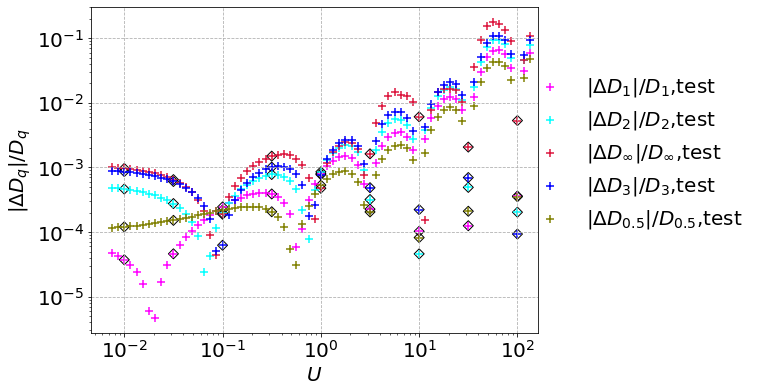

In [16]:
U_test = np.logspace(-2.125, 2.125, 69, endpoint = True) 
plt.figure(figsize=(8,6))


q=1
D1e=[]
for U in U_train:
    gs_vecs = np.genfromtxt(f'./2D-exact_states/M-{M}-N-{N}-w{w}-h{h}/{U}.csv')
    #gs_vecs_test = np.genfromtxt(f'./exact_states/M-{M}-N-{N}/{U}.csv')
    gs_frac = -np.sum(np.power(gs_vecs,2*q)*np.log(np.power(gs_vecs,2*q)))
    D1e.append(gs_frac/np.log(model.tot_states))
#plt.plot(U_test,D1,label=r'$D_1$,exact')


q=1
D1=[]
for U in U_train:
    gs_vecs = np.genfromtxt(f'./2D-states/2D-ADAM-M-{M}-N-{N}-U_train-{U_train}-lr-{lr}-w{w}-h{h}/U_train-{U}.csv')
    gs_frac = -np.sum(np.power(gs_vecs,2*q)*np.log(np.power(gs_vecs,2*q)))
    D1.append(gs_frac/np.log(model.tot_states))
#plt.scatter(U_train,D1,label=r'$D_1$,train',color='black',s=50)
plt.scatter(U_train,np.abs(np.array(D1)-np.array(D1e))/np.array(D1e),color='black',s=50,marker='D',facecolors='none')


q=2
D2e=[]
for U in U_train:
    gs_vecs = np.genfromtxt(f'./2D-exact_states/M-{M}-N-{N}-w{w}-h{h}/{U}.csv')
    gs_frac = 1/(1-q)*np.log(np.sum(np.power(gs_vecs,2*q)))
    D2e.append(gs_frac/np.log(model.tot_states))
#plt.plot(U_test,D2,label=r'$D_2$,exact')

q=2
D2=[]
for U in U_train:
    gs_vecs = np.genfromtxt(f'./2D-states/2D-ADAM-M-{M}-N-{N}-U_train-{U_train}-lr-{lr}-w{w}-h{h}/U_train-{U}.csv')
    gs_frac = 1/(1-q)*np.log(np.sum(np.power(gs_vecs,2*q)))
    D2.append(gs_frac/np.log(model.tot_states))
#plt.scatter(U_train,D2,color='black',marker='s',s=50)
plt.scatter(U_train,np.abs(np.array(D2)-np.array(D2e))/np.array(D2e),color='black',s=50,marker='D',facecolors='none')
plt.xscale('log')
plt.xlabel(r'$U$')
plt.ylabel(r'$D_q$')
#plt.legend()



Dinfe=[]
for U in U_train:
    gs_vecs = np.genfromtxt(f'./2D-exact_states/M-{M}-N-{N}-w{w}-h{h}/{U}.csv')
    gs_frac = -np.log(np.max(np.power(np.abs(gs_vecs),2)))
    Dinfe.append(gs_frac/np.log(model.tot_states))
#plt.plot(U_test,Dinf,label=r'$D_\infty$,exact')

Dinf=[]
for U in U_train:
    gs_vecs = np.genfromtxt(f'./2D-states/2D-ADAM-M-{M}-N-{N}-U_train-{U_train}-lr-{lr}-w{w}-h{h}/U_train-{U}.csv')
    gs_frac = -np.log(np.max(np.power(np.abs(gs_vecs),2)))
    Dinf.append(gs_frac/np.log(model.tot_states))
#plt.scatter(U_train,Dinf,label=r'$D_\infty$,train',color='black',marker='s',s=50)
plt.scatter(U_train,np.abs(np.array(Dinf)-np.array(Dinfe))/np.array(Dinfe),color='black',marker='D',s=50,facecolors='none')
plt.xscale('log')
plt.xlabel(r'$U$')
plt.ylabel(r'$D_q$')
#plt.legend()



q=3
D3e=[]
for U in U_train:
    gs_vecs = np.genfromtxt(f'./2D-exact_states/M-{M}-N-{N}-w{w}-h{h}/{U}.csv')
    gs_frac = 1/(1-q)*np.log(np.sum(np.power(gs_vecs,2*q)))
    D3e.append(gs_frac/np.log(model.tot_states))
#plt.plot(U_test,D3,label=r'$D_3$,exact')


q=3
D3=[]
for U in U_train:
    gs_vecs = np.genfromtxt(f'./2D-states/2D-ADAM-M-{M}-N-{N}-U_train-{U_train}-lr-{lr}-w{w}-h{h}/U_train-{U}.csv')
    gs_frac = 1/(1-q)*np.log(np.sum(np.power(gs_vecs,2*q)))
    D3.append(gs_frac/np.log(model.tot_states))
#plt.scatter(U_train,D2,color='black',marker='s',s=50)
plt.scatter(U_train,np.abs(np.array(D3)-np.array(D3e))/np.array(D3e),color='black',s=50,marker='D',facecolors='none')
plt.xscale('log')
plt.xlabel(r'$U$')
plt.ylabel(r'$D_q$')
#plt.legend()



q=0.5
Dhalfe=[]
for U in U_train:
    gs_vecs = np.genfromtxt(f'./2D-exact_states/M-{M}-N-{N}-w{w}-h{h}/{U}.csv')
    gs_frac = 1/(1-q)*np.log(np.sum(np.power(np.abs(gs_vecs),2*q)))
    Dhalfe.append(gs_frac/np.log(model.tot_states))
#plt.plot(U_test,Dhalf,label='$D_{0.5}$,exact')

q=0.5
Dhalf=[]
for U in U_train:
    gs_vecs = np.genfromtxt(f'./2D-states/2D-ADAM-M-{M}-N-{N}-U_train-{U_train}-lr-{lr}-w{w}-h{h}/U_train-{U}.csv')
    gs_frac = 1/(1-q)*np.log(np.sum(np.power(np.abs(gs_vecs),2*q)))
    Dhalf.append(gs_frac/np.log(model.tot_states))
#plt.scatter(U_train,D2,color='black',marker='s',s=50)
plt.scatter(U_train,np.abs(np.array(Dhalf)-np.array(Dhalfe))/np.array(Dhalfe),color='black',s=50,marker='D',facecolors='none')
plt.xscale('log')
plt.xlabel(r'$U$')
plt.ylabel(r'$D_q$')
#plt.legend()






q=1
D1e=[]
for U in U_test:
    gs_vecs = np.genfromtxt(f'./2D-exact_states/M-{M}-N-{N}-w{w}-h{h}/{U}.csv')
    #gs_vecs_test = np.genfromtxt(f'./exact_states/M-{M}-N-{N}/{U}.csv')
    gs_frac = -np.sum(np.power(gs_vecs,2*q)*np.log(np.power(gs_vecs,2*q)))
    D1e.append(gs_frac/np.log(model.tot_states))
#plt.plot(U_test,D1,label=r'$D_1$,exact')

q=1
D1=[]
for U in U_test:
    gs_vecs = np.genfromtxt(f'./2D-states/2D-ADAM-M-{M}-N-{N}-U_test-{U_train}-lr-{lr}-w{w}-h{h}/U_test-{U}.csv')
    gs_frac = -np.sum(np.power(gs_vecs,2*q)*np.log(np.power(gs_vecs,2*q)))
    D1.append(gs_frac/np.log(model.tot_states))
plt.scatter(U_test,np.abs(np.array(D1)-np.array(D1e))/np.array(D1e),label=r'$|\Delta D_1|/D_1$,test',marker='+',s=50,color='magenta')


q=2
D2e=[]
for U in U_test:
    gs_vecs = np.genfromtxt(f'./2D-exact_states/M-{M}-N-{N}-w{w}-h{h}/{U}.csv')
    gs_frac = 1/(1-q)*np.log(np.sum(np.power(gs_vecs,2*q)))
    D2e.append(gs_frac/np.log(model.tot_states))
#plt.plot(U_test,D2,label=r'$D_2$,exact')

q=2
D2=[]
for U in U_test:
    gs_vecs = np.genfromtxt(f'./2D-states/2D-ADAM-M-{M}-N-{N}-U_test-{U_train}-lr-{lr}-w{w}-h{h}/U_test-{U}.csv')
    gs_frac = 1/(1-q)*np.log(np.sum(np.power(gs_vecs,2*q)))
    D2.append(gs_frac/np.log(model.tot_states))
plt.scatter(U_test,np.abs(np.array(D2)-np.array(D2e))/np.array(D2e),label=r'$|\Delta D_2|/D_2$,test',marker='+',s=50,color='cyan')
plt.xscale('log')
plt.xlabel(r'$U$')
plt.ylabel(r'$D_q$')
plt.legend()


Dinfe=[]
for U in U_test:
    gs_vecs = np.genfromtxt(f'./2D-exact_states/M-{M}-N-{N}-w{w}-h{h}/{U}.csv')
    gs_frac = -np.log(np.max(np.power(np.abs(gs_vecs),2)))
    Dinfe.append(gs_frac/np.log(model.tot_states))
#plt.plot(U_test,Dinf,label=r'$D_\infty$,exact')


Dinf=[]
for U in U_test:
    gs_vecs = np.genfromtxt(f'./2D-states/2D-ADAM-M-{M}-N-{N}-U_test-{U_train}-lr-{lr}-w{w}-h{h}/U_test-{U}.csv')
    gs_frac = -np.log(np.max(np.power(np.abs(gs_vecs),2)))
    Dinf.append(gs_frac/np.log(model.tot_states))
plt.scatter(U_test,np.abs(np.array(Dinf)-np.array(Dinfe))/np.array(Dinfe),label=r'$|\Delta D_\infty|/D_\infty$,test',marker='+',s=50,color='crimson')
plt.xscale('log')
plt.xlabel(r'$U$')
plt.ylabel(r'$D_q$')
plt.legend()



q=3
D3e=[]
for U in U_test:
    gs_vecs = np.genfromtxt(f'./2D-exact_states/M-{M}-N-{N}-w{w}-h{h}/{U}.csv')
    gs_frac = 1/(1-q)*np.log(np.sum(np.power(gs_vecs,2*q)))
    D3e.append(gs_frac/np.log(model.tot_states))
#plt.plot(U_test,D3,label=r'$D_3$,exact')


q=3
D3=[]
for U in U_test:
    gs_vecs = np.genfromtxt(f'./2D-states/2D-ADAM-M-{M}-N-{N}-U_test-{U_train}-lr-{lr}-w{w}-h{h}/U_test-{U}.csv')
    gs_frac = 1/(1-q)*np.log(np.sum(np.power(gs_vecs,2*q)))
    D3.append(gs_frac/np.log(model.tot_states))
plt.scatter(U_test,np.abs(np.array(D3)-np.array(D3e))/np.array(D3e),label=r'$|\Delta D_3|/D_3$,test',marker='+',s=50,color='blue')
plt.xscale('log')
plt.xlabel(r'$U$')
plt.ylabel(r'$D_q$')
plt.legend()


q=0.5
Dhalfe=[]
for U in U_test:
    gs_vecs = np.genfromtxt(f'./2D-exact_states/M-{M}-N-{N}-w{w}-h{h}/{U}.csv')
    gs_frac = 1/(1-q)*np.log(np.sum(np.power(np.abs(gs_vecs),2*q)))
    Dhalfe.append(gs_frac/np.log(model.tot_states))
#plt.plot(U_test,Dhalf,label='$D_{0.5}$,exact')

q=0.5
Dhalf=[]
for U in U_test:
    gs_vecs = np.genfromtxt(f'./2D-states/2D-ADAM-M-{M}-N-{N}-U_test-{U_train}-lr-{lr}-w{w}-h{h}/U_test-{U}.csv')
    gs_frac = 1/(1-q)*np.log(np.sum(np.power(np.abs(gs_vecs),2*q)))
    Dhalf.append(gs_frac/np.log(model.tot_states))
plt.scatter(U_test,np.abs(np.array(Dhalf)-np.array(Dhalfe))/np.array(Dhalfe),label='$|\Delta D_{0.5}|/D_{0.5}$,test',marker='+',s=50,color='olive')
plt.xscale('log')
plt.xlabel(r'$U$')
plt.ylabel(r'$D_q$')
plt.legend(fontsize=20,frameon=False,loc='center right')









#plt.hlines(y=0.01,xmin=0.,xmax=160,color="black",linestyle='dashed',lw=3)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$U$',fontsize=20)
plt.ylabel(r'$|\Delta D_q|/D_q$',fontsize=20)
plt.legend(fontsize=20,frameon=False,loc='center right',bbox_to_anchor=(0.5, 0.5, 1., .102))
#plt.legend(fontsize=20,frameon=False,loc='center right')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlim(0,160)
#plt.savefig(f'./new-loss/new-figures/Dq/Dq-ADAM-cc-{cc}-M-{M}-N-{N}-lr-{lr}-U_train-{U_train}.pdf')
#plt.savefig(f'./figures/report/Dq/Dq-ADAM-cc-{cc}-M-{M}-N-{N}-lr-{lr}-U_train-{U_train}.pdf')
plt.grid(linestyle='dashed')
plt.savefig(f"./paper-2D-ground-state/2D-ground-state-deltaDqDq-M-{M}-N-{N}-w-{w}-h{h}-len_U_train-{len(U_train)}-all.pdf",bbox_inches='tight',dpi=1000)
plt.show()


In [6]:
def frac_dq(vector,q):
    if q==1:
        gs_frac = -np.sum(np.power(np.abs(gs_vecs),2*q)*np.log(np.power(np.abs(gs_vecs),2*q)))
        
    elif q>=1e5:
        gs_frac = -np.log(np.max(np.power(np.abs(gs_vecs),2)))
        
    else:
        gs_frac = 1/(1-q)*np.log(np.sum(np.power(np.abs(gs_vecs),2*q)))
        
    return gs_frac


In [7]:
qlist=[1,2]

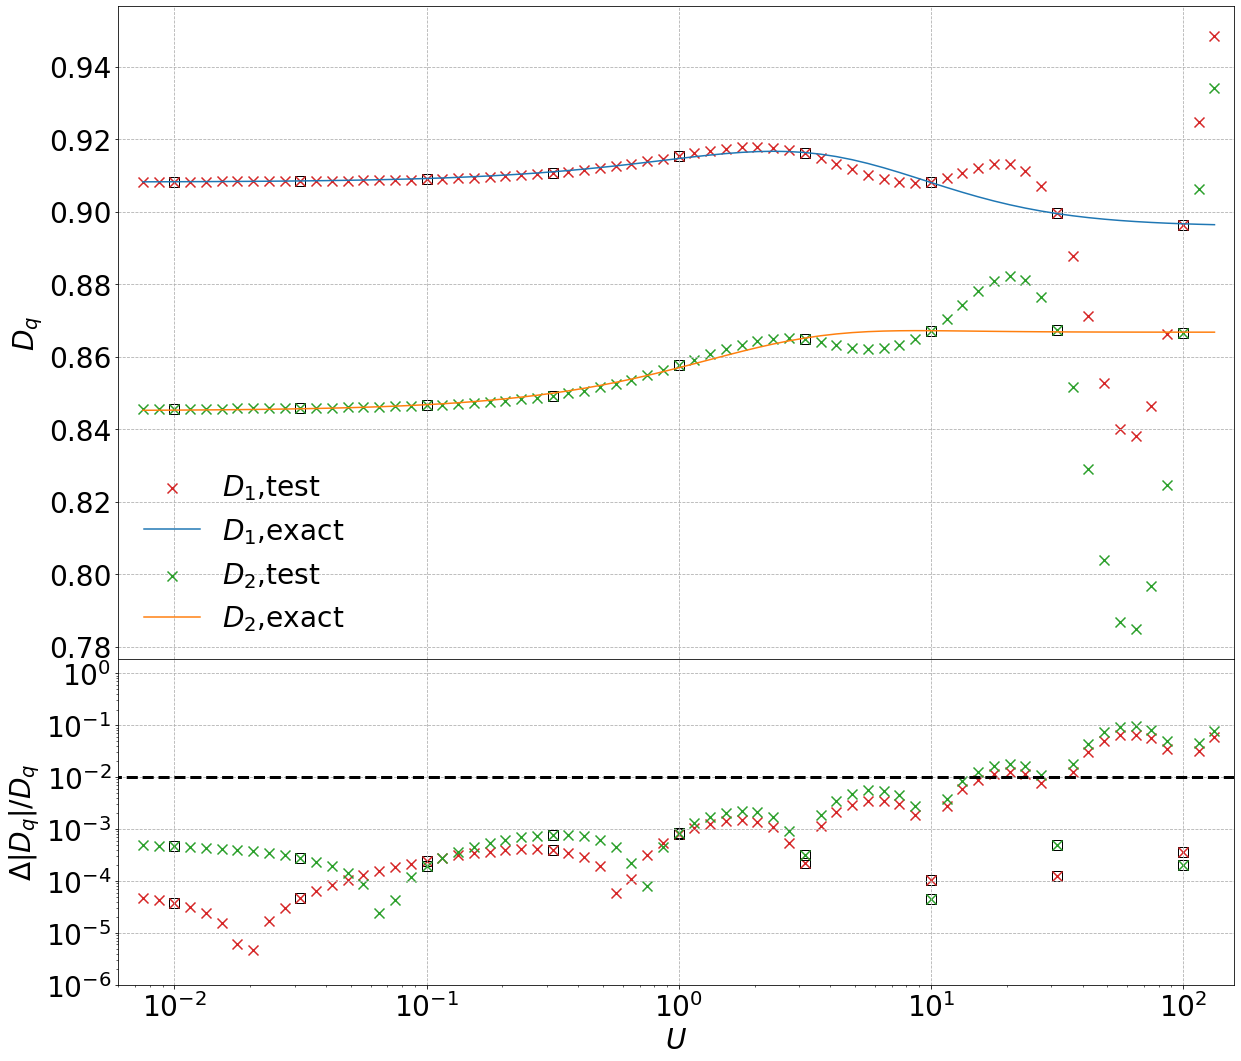

In [12]:
U_test = np.logspace(-2.125, 2.125, 69, endpoint = True)
fig,(ax1,ax2) = plt.subplots(2,1,figsize=(20, 18), sharex=True, gridspec_kw={'height_ratios': [2,1]})
fig.subplots_adjust(hspace=0)



markerslist=['s','x','x','x','x','x']
cmap = plt.get_cmap('jet', len(qlist))
colors=['magenta','cyan','crimson','blue','olive','brown']
#colors1=['blue','orange','green','red','purple']
colors1=['C0','C1','C2','C3','C4']
colors2=['C3','C2','C4']
colors3=['black','dimgray','dimgrey','silver','gray']
idx=0
#plt.figure(figsize=(8,6))
for q in [1, 2]:
    Dqt=[]
    for U in U_train:
        gs_vecs = np.genfromtxt(f'./2D-states/2D-ADAM-M-{M}-N-{N}-U_train-{U_train}-lr-{lr}-w{w}-h{h}/U_train-{U}.csv')
        gs_frac = frac_dq(gs_vecs,q)
        Dqt.append(gs_frac/np.log(model.tot_states))
    if q<1e4:
        #plt.scatter(U_train,Dq,label=f'$D_{q}$,train',color='black',marker=markerslist[qlist1.index(q)],s=50)
        #plt.scatter(U_train,Dq,color='black',marker='s',s=50,facecolors='none')
        ax1.scatter(U_train,Dqt,color='black',s=100,marker='s',facecolors='none')
    else:
        #plt.scatter(U_train,Dq,label=r'$D_{\infty}$,train',color='black',marker=markerslist[qlist1.index(q)],s=50)
        #plt.scatter(U_train,Dq,color='black',marker='s',s=50,facecolors='none')
        ax1.scatter(U_train,Dqt,color='black',s=100,marker='s',facecolors='none')
    plt.xscale('log')
    plt.xlabel('U')
    plt.ylabel(r'$D_q$')
    #plt.legend()


    Dq=[]
    for U in U_test:
        gs_vecs = np.genfromtxt(f'./2D-states/2D-ADAM-M-{M}-N-{N}-U_test-{U_train}-lr-{lr}-w{w}-h{h}/U_test-{U}.csv')
        gs_frac = frac_dq(gs_vecs,q)
        Dq.append(gs_frac/np.log(model.tot_states))
    if q<1e4 and q!=0.5:
        ax1.scatter(U_test,Dq,label=f'$D_{q}$,test',color=colors2[idx],s=100,marker='+')
    elif q==0.5:
        ax1.scatter(U_test,Dq,label='$D_{0.5}$,test',color=colors2[idx],s=100,marker='+')
    else:
        ax1.scatter(U_test,Dq,label=r'$D_{\infty}$,test',color=colors2[idx],s=100,marker='+')
    plt.xscale('log')
    plt.xlabel('U')
    plt.ylabel(r'$D_q$')
    #plt.legend()
    #idx=idx+1

    Dqe=[]
    for U in U_test:
        gs_vecs = np.genfromtxt(f'./2D-exact_states/M-{M}-N-{N}-w{w}-h{h}/{U}.csv')
        gs_frac = frac_dq(gs_vecs,q)
        Dqe.append(gs_frac/np.log(model.tot_states))
    if q<1e4 and q!=0.5:
        ax1.plot(U_test,Dqe,label=f'$D_{q}$,exact',color=colors1[idx])
    elif q==0.5:
        ax1.plot(U_test,Dqe,label='$D_{0.5}$,exact',color=colors1[idx])
    else:
        ax1.plot(U_test,Dqe,label=r'$D_{\infty}$,exact',color=colors1[idx])
    
    
    Dqee=[]
    for U in U_train:
        gs_vecs = np.genfromtxt(f'./2D-exact_states/M-{M}-N-{N}-w{w}-h{h}/{U}.csv')
        gs_frac = frac_dq(gs_vecs,q)
        Dqee.append(gs_frac/np.log(model.tot_states))
    
    ax2.scatter(U_train,np.abs(np.array(Dqt)-np.array(Dqee))/np.array(Dqee),color='black',marker='s',s=100,facecolors='none')
    ax2.scatter(U_test,np.abs(np.array(Dq)-np.array(Dqe))/np.abs(np.array(Dqe)),color=colors2[idx],marker='+',s=100)
    #idx=idx+1
    
    
    idx=idx+1
#plt.ylim(0.2,0.93)
plt.xscale('log')
plt.xlabel(r'$U$',fontsize=28)
ax1.legend(fontsize=28,frameon=False,loc='lower left')
ax1.set_ylabel(r'$D_q$',fontsize=28)
ax2.set_ylabel(r'$\Delta |D_q|/D_q$',fontsize=28)
ax2.set_yscale('log')
ax1.tick_params(axis='both', which='major', labelsize=28)
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.hlines(y=0.01,xmin=0.,xmax=160,color="black",linestyle='dashed',lw=3)

#plt.vlines(x=0.2053525026457146,ymin=0.,ymax=1,color="black",linestyle='dashed',lw=3)
#plt.vlines(x=2.0535250264571463,ymin=0.,ymax=1,color="black",linestyle='dashed',lw=3)
#plt.vlines(x=20.53525026457146,ymin=0.,ymax=1,color="black",linestyle='dashed',lw=3)
#plt.legend(fontsize=28,frameon=False,loc='upper left')
#plt.legend(fontsize=28,frameon=False,loc='lower left',bbox_to_anchor=(-0.04,0))
ax1.grid(linestyle='dashed')
ax2.grid(linestyle='dashed')
plt.xlim(0.006,160)
plt.ylim(1e-6,1.9)
#fig.tight_layout()
plt.savefig(f"./paper-2D-ground-state/2D-ground-state-Dq-deltaDqDq-M-{M}-N-{N}-len_U_train-{len(U_train)}.pdf",bbox_inches='tight',dpi=1000)
plt.show()


/tmp/ipykernel_2355910/3716681604.py:34: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(0.,160)


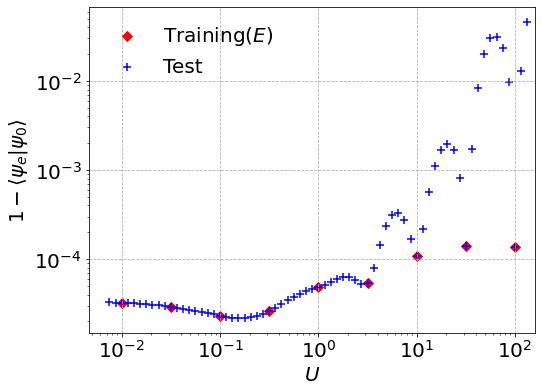

In [10]:
fig,ax=plt.subplots(figsize=(8,6))




overlap=[]
for (i,U) in enumerate(U_train):
    wf_nn=np.genfromtxt(f'./2D-states/2D-ADAM-M-{M}-N-{N}-U_train-{U_train}-lr-{lr}-w{w}-h{h}/U_train-{U}.csv')
    wf_exact=np.genfromtxt(f'./2D-exact_states/M-{M}-N-{N}-w{w}-h{h}/{U}.csv')
    overlap.append(np.dot(wf_exact,wf_nn))
ax.scatter(U_train,np.ones(len(U_train))-overlap,s=50,c='r', marker='D',label='Training($E$)')
#print(np.ones(len(U_train))-overlap)

overlap=[]
for (i,U) in enumerate(U_test):
    wf_nn=np.genfromtxt(f'./2D-states/2D-ADAM-M-{M}-N-{N}-U_test-{U_train}-lr-{lr}-w{w}-h{h}/U_test-{U}.csv')
    wf_exact=np.genfromtxt(f'./2D-exact_states/M-{M}-N-{N}-w{w}-h{h}/{U}.csv')
    overlap.append(np.dot(wf_exact,wf_nn))
#plt.plot(U_test,np.ones(len(U_test))-overlap,'.-',label='ADAM-with-overlap-loss-c=1')
#ax.scatter(U_test,np.ones(len(U_test))-overlap,s=100, c='b', marker='x',label='Test',lw=2)
#ax.plot(U_test,np.ones(len(U_test))-overlap,markersize=15, c='b', marker='x',label='Test',lw=2)
ax.scatter(U_test,np.ones(len(U_test))-overlap,s=50, c='b', marker='+',label='Test')
#print(np.ones(len(U_test))-overlap)



plt.xscale("log")
plt.xlabel(r'$U$',fontsize=20)
#plt.ylabel(r'$1-\langle\psi_e (\mathbf{n})|\psi_{test} (\mathbf{n}) \rangle$',fontsize=20)
plt.ylabel(r'$1-\langle\psi_e |\psi_0  \rangle$',fontsize=20)
#plt.axvline(x=3.12,c="green",linestyle='dashed')
plt.legend(frameon=False,prop={'size': 20})

plt.xlim(0.,160)
#plt.ylim(5e-5,0.01)
plt.yscale('log')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
ax.grid(linestyle='dashed')

#plt.axvline(x=35,ymin=mini,ymax=maxi,c="red",linestyle='dashed')
#plt.axvline(x=15,ymin=mini,ymax=maxi,c="blue",linestyle='dashed')
#plt.axvline(x=50,ymin=mini,ymax=maxi,c="orange",linestyle='dashed')
#plt.axvline(x=0.05,ymin=mini,ymax=maxi,c="red",linestyle='dashed')
#plt.axvline(x=2,ymin=mini,ymax=maxi,c="pink",linestyle='dashed')
#plt.axvline(x=5,ymin=mini,ymax=maxi,c="purple",linestyle='dashed')
#plt.axvline(x=0.5,ymin=mini,ymax=maxi,c="yellow",linestyle='dashed')
#plt.axvline(x=50,ymin=mini,ymax=maxi,c="magenta",linestyle='dashed')
#plt.axvline(x=75,ymin=mini,ymax=maxi,c="cyan",linestyle='dashed')
#plt.axvline(x=100,ymin=mini,ymax=maxi,c="grey",linestyle='dashed')
#plt.savefig(f'./new-loss/new-figures/1-overlap/ADAM-VS-ADAMov-cc-{cc}-M-{M}-N-{N}-lr-{lr}-U_test-{U_train}.pdf')
#plt.savefig(f'./regensburg/cc-{cc}-M-{M}-N-{N}-lr-{lr}-U_test-{U_train}.pdf', format='pdf',bbox_inches='tight',dpi=1000)
fig.savefig(f"./paper-2D-ground-state/2D-ground-state-overlap-M-{M}-N-{N}-w-{w}-h-{h}.pdf",bbox_inches='tight',dpi=1000)
plt.show()

In [5]:
fc_gs = load_weights(fname + "gs", M, D_hid)

Loading existing weights...


In [6]:
aa=fc_gs.state_dict()

In [32]:
max(aa['Lin_1.weight'].cpu().detach().numpy()[:,10])

0.22642961540872722

In [22]:
len(aa['Lin_1.bias'].cpu().detach().numpy())

400

In [11]:
aa

OrderedDict([('Lin_1.weight',
              tensor([[ 0.1117, -0.0129,  0.0860,  ...,  0.1975, -0.1105, -0.0429],
                      [-0.0941,  0.1448,  0.0436,  ..., -0.0200, -0.1614,  0.0941],
                      [ 0.1208, -0.1001,  0.0065,  ...,  0.1344, -0.1567, -0.1633],
                      ...,
                      [-0.0624, -0.0120,  0.1042,  ...,  0.1659, -0.1219, -0.0891],
                      [ 0.1801, -0.1652,  0.0475,  ..., -0.0849,  0.2056,  0.0474],
                      [-0.1552, -0.0236, -0.0973,  ..., -0.0590,  0.0774, -0.0448]])),
             ('Lin_1.bias',
              tensor([-0.1553,  0.1505, -0.0622,  0.0053,  0.1188,  0.1754, -0.1216,  0.1677,
                      -0.0717,  0.1774, -0.1737,  0.0317, -0.2134, -0.0044,  0.1238,  0.0434,
                       0.2063,  0.0930,  0.1480, -0.0819,  0.1035, -0.0147,  0.0494, -0.0128,
                       0.0164, -0.0859,  0.1480, -0.0806, -0.2197,  0.0040, -0.1875,  0.0012,
                       0.1196, -

<AxesSubplot:>

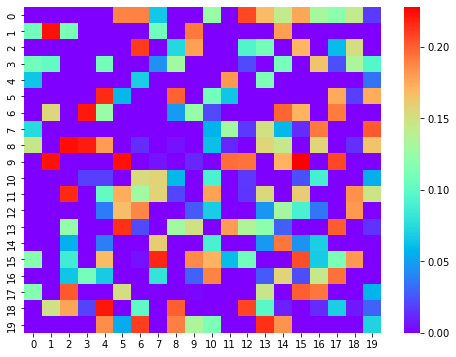

In [13]:
import seaborn as sns
fig,ax=plt.subplots(figsize=(8,6))
phase=fc_gs.state_dict()['Lin_1.weight'].cpu().detach().numpy()[:,10].reshape(20,20)
sns.heatmap(np.flipud(phase),ax=ax,vmin=0.,vmax=np.max(phase),cmap="rainbow")

<AxesSubplot:>

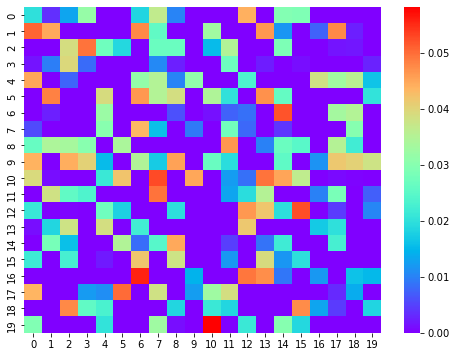

In [14]:
import seaborn as sns
fig,ax=plt.subplots(figsize=(8,6))
phase=fc_gs.state_dict()['Lin_2.weight'].cpu().detach().numpy()[:,10].reshape(20,20)
sns.heatmap(np.flipud(phase),ax=ax,vmin=0.,vmax=np.max(phase),cmap="rainbow")

<AxesSubplot:>

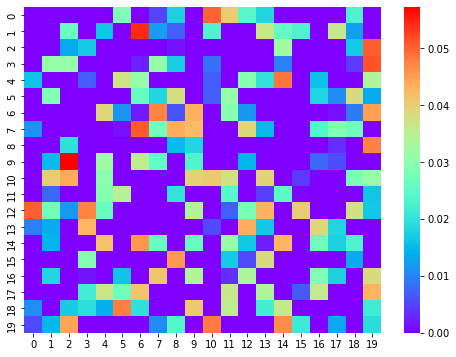

In [15]:
import seaborn as sns
fig,ax=plt.subplots(figsize=(8,6))
phase=fc_gs.state_dict()['Lin_3.weight'].cpu().detach().numpy()[:,10].reshape(20,20)
sns.heatmap(np.flipud(phase),ax=ax,vmin=0.,vmax=np.max(phase),cmap="rainbow")

<AxesSubplot:>

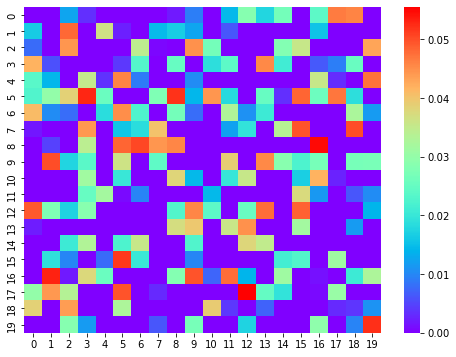

In [16]:
import seaborn as sns
fig,ax=plt.subplots(figsize=(8,6))
phase=fc_gs.state_dict()['Lin_4.weight'].cpu().detach().numpy()[:,10].reshape(20,20)
sns.heatmap(np.flipud(phase),ax=ax,vmin=0.,vmax=np.max(phase),cmap="rainbow")

<AxesSubplot:>

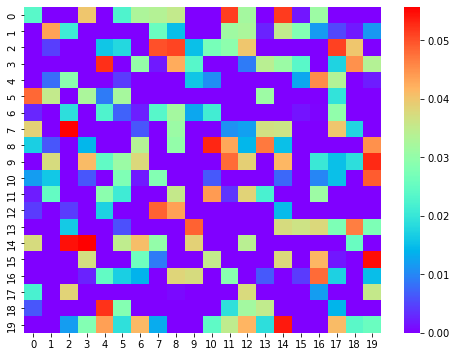

In [17]:
import seaborn as sns
fig,ax=plt.subplots(figsize=(8,6))
phase=fc_gs.state_dict()['Lin_5.weight'].cpu().detach().numpy()[:,10].reshape(20,20)
sns.heatmap(np.flipud(phase),ax=ax,vmin=0.,vmax=np.max(phase),cmap="rainbow")

In [9]:
fc_gs=torch.load(fname + "gs")

In [11]:
fc_gs['loss']

tensor(-9.2344, requires_grad=True)